# Figures (final)

In [1]:
%matplotlib inline
import sys 
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
import pickle
from pathlib import Path
from itertools import product

modpath = "../scripts"
sys.path.append(os.path.abspath(modpath))

from misc import pickler, open_table
import plot_utils

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# pretty names
prdea = {"edgerlrt":"edgeR LRT","edgerqlf":"edgeR QLF","deseq2":"DESeq2 Wald","deseq2_apeglm":"DESeq2 apeglm","deseq2_ashr":"DESeq2 ashr",
         "DESeq2":"DESeq2 Wald","wilcox":"Wilcoxon rank-sum"}
prdata = {"BASHER":"BSHR","BASLUMA":"BSLA","LWPL":"GATB","BASLUMB":"BSLB","LUMAB":"LMAB","HERLUMA":"HRLA","HERLUMB":"HRLB"}
prdata_inv = {v:k for k,v in prdata.items()}

pretty_met = {"mcc": "MCC",
             "rec": "Recall",
             "rep": "Replicability",
             "prec": "Precision",
             "deg": "#DEGs",
             "terms": "#Terms",
              "std":"std",
              "kurt":"Kurtosis",
             "Spear": "Spearman correlation", "KL":"KL Divergence","Rep":"Replicability","Prec":"Precision","Rec":"Recall"
             }

# param sets
def get_paramset(data):
    if data in ["BSHR","BSLA","BSLB","LMAB","HRLA","HRLB","GIPF","HSPL"]:
        return "p2c"
    elif data in ["SNF2","GATB","FMPL"]:
        return "p3"
    elif data in ["BRCA","COAD","KIRC","LIHC","LUAD","LUSC","PRAD","THCA"]:
        return "p2"
    else:
        print("Invalid data:", data)
        
sites = {"liver": "LIHC",
         "thyroid": "THCA",
         "lung": "LUAD",
         "lung2": "LUSC",
         "kidney": "KIRC",
         "colorectal": "COAD",
         "breast": "BRCA",
         "prostate": "PRAD"}

sites_unpaired = {
         "GSETB":"LWPL",
         #"pregnancy2":"FMPL", # almost no DEGs, no enrichment
         "yeast":"SNF2"
}

sites_custom_design = {
            "GSEPN":"GIPF", # Pulmonary fibrosis
            "breast_basher": "BASHER", # Basal vs HER2+
            "breast_basluma": "BASLUMA", # Basal vs Luminal A
            "breast_baslumb": "BASLUMB", # Basal vs Luminal B
            "breast_herluma": "HERLUMA", # HER2 vs Luminal A
            "breast_herlumb": "HERLUMB", # HER2 vs Luminal B
            "breast_lumab": "LUMAB", # LumA vs LumB
            "pregnancy": "HSPL", # 1st vs 3rd trimester
}

sites = sites | sites_unpaired | sites_custom_design
used_data = [prdata[s] if s in prdata else s for s in sites.values()]
sites_inv = {v:k for k,v in sites.items()}

os.environ['R_HOME'] = '/storage/homefs/pd21v747/.conda/rna-rep/lib/R/'

In [2]:
# Load differential expression data

combined_all = pd.read_csv("../data/multi/combined_all.csv", index_col=0)
combined_all["Out"].fillna("None", inplace=True)
combined_all = combined_all[~combined_all["isSynthetic"]]
combined_all = combined_all[combined_all["Data"].isin(used_data)]
combined_all.head()

,Data,N,Out,DEA,FDR,logFC,median_deg,median_deg_method,median_mcc,median_mcc0,...,median_prec0,median_prec0_method,median_prec_method,median_rec,median_rec_method,median_rep,median_rep_method,id,lfc_mode,isSynthetic
0,BRCA,3,None,DESeq2 Wald,0.05,0,2294.5,2294.5,0.165280,0.165280,...,0.955180,0.970185,0.970185,0.151784,0.145621,0.269616,0.269616,0,post_hoc,False
1,BRCA,3,None,DESeq2 Wald,0.05,1,2161.0,2161.0,0.497009,0.497009,...,0.753902,0.765557,0.765557,0.449721,0.435682,0.270566,0.270566,0,post_hoc,False
2,BRCA,3,None,edgeR LRT,0.05,0,1493.5,1493.5,0.142766,0.142766,...,0.966497,0.971890,0.971890,0.104152,0.100655,0.200720,0.200720,0,post_hoc,False
3,BRCA,3,None,edgeR LRT,0.05,1,1493.5,1493.5,0.437583,0.437583,...,0.810135,0.821953,0.821953,0.316061,0.308851,0.200959,0.200959,0,post_hoc,False
4,BRCA,3,None,edgeR QLF,0.05,0,0.0,0.0,0.062313,0.000000,...,0.000000,0.000000,0.989879,0.000000,0.000000,0.000000,0.000000,0,post_hoc,False


In [4]:
# Load enrichment data

combined_gsea = pd.read_csv(f"../data/multi/combined_gsea_td.rev3.csv", index_col=0)
combined_gsea["Out"].fillna("None", inplace=True)
combined_gsea["Data"].replace(prdata, inplace=True)
combined_gsea = combined_gsea[combined_gsea["Data"].isin(used_data)]

dea = "DESeq2 Wald"
logFC = 1
lfc_mode = "formal"
fdr = 0.05

c = combined_all[~combined_all["isSynthetic"]]
c = c[(c["Out"]=="None") & (c["logFC"]==logFC) & (c["FDR"]==fdr) & (c["lfc_mode"] == lfc_mode) & (c["DEA"]==dea)]
order_rep = c[c["N"]==15].sort_values(by="median_rep_method")["Data"].values
print(order_rep)

combined_gsea.head()

['LMAB' 'HRLB' 'HRLA' 'GIPF' 'PRAD' 'BSHR' 'BSLB' 'BSLA' 'GATB' 'LIHC'
 'THCA' 'BRCA' 'KIRC' 'LUAD' 'COAD' 'LUSC' 'HSPL' 'SNF2']


,Data,N,Out,DEA,Enrichment,Library,Ranking,FDR,median_mcc,median_mcc0,median_prec,median_prec0,median_rec,median_rep,median_terms,id
0,BSHR,3,None,DESeq2,gseapy,GO_Biological_Process,logFC,0.05,0.086656,0.081561,0.058333,0.057143,0.105263,0.022347,31.0,0
1,BSHR,3,None,DESeq2,gseapy,KEGG,logFC,0.05,0.118330,0.116316,0.100000,0.100000,0.222222,0.052632,17.5,0
2,BSHR,3,None,deseq2_ashr,gseapy,GO_Biological_Process,logFC,0.05,-0.001503,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,0
3,BSHR,3,None,deseq2_ashr,gseapy,KEGG,logFC,0.05,-0.008318,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,0
4,BSHR,5,None,DESeq2,gseapy,GO_Biological_Process,logFC,0.05,0.160657,0.160508,0.116026,0.113248,0.210526,0.031915,31.0,1


In [5]:
## Plotting

npg = plot_utils.npg_palette()
jco = plot_utils.jco_palette()
colors=plot_utils.matplotlib_init()
palette = jco[:len(order_rep)]
palette = sns.color_palette("crest", n_colors=len(order_rep))
#palette = palette[1:-1]
palette_ordered = {data: color for data, color in zip(order_rep, palette[:len(order_rep)])}
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})
boxprops = dict(boxstyle='round', facecolor='#e4eaf3', alpha=1, edgecolor="#2a3b76")

In [6]:
datasetsfile = "../data/multi/datasets.txt"

with open(datasetsfile, "rb") as f:
    datasets = pickle.load(f)
    datasets = {k:datasets[k] for k in sites.values()}

keys = [k for k in datasets]
for data in keys:
    if "SBRCA" in data:
        del datasets[data]

N_tot = [datasets[d]["patients"] for d in datasets]
print(f"Median N: {np.median(N_tot)}, Range: {min(N_tot)}--{max(N_tot)}, Datasets: {len(N_tot)}")
datasets.keys()

Median N: 58.5, Range: 39--161, Datasets: 18


dict_keys(['LIHC', 'THCA', 'LUAD', 'LUSC', 'KIRC', 'COAD', 'BRCA', 'PRAD', 'LWPL', 'SNF2', 'GIPF', 'BASHER', 'BASLUMA', 'BASLUMB', 'HERLUMA', 'HERLUMB', 'LUMAB', 'HSPL'])

## Load bootstrapping df

This df contains computed statistics (Spearman correlation, KL divergence) for all data sets, $k=25$ trials, $N\in\{{5,10}\}$, and 50 cohorts. The statistics are computed by comparing the trial logFC destribution with 1) the ground truth and 2) the original subsampled cohort logFC distribution.

In [7]:
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.metrics import auc

df_boot = pd.read_csv("../data/multi/df_boot_long.csv", index_col=0)

Next, we construct another df that contains Spearman and KL statistics aggregated over all trials. Additionally, the df contains the performance metrics (precision, recall, replicability) of the respective data set.

In [11]:
all_N = [5,10]
ref = "Cohort"

dfm = pd.DataFrame(index = list(set(combined_all["Data"])))
for N_ in all_N:
    c = combined_all
    c = c[(c["N"]==N_)&(c["DEA"]=="DESeq2 Wald")&(c["logFC"]==1)&(c["lfc_mode"]=="formal")]
    c.set_index("Data", inplace=True)
    dfm[f"Prec_N{N_}"] = c["median_prec"]
    dfm[f"Rec_N{N_}"] = c["median_rec"]
    dfm[f"Rep_N{N_}"] = c["median_rep"]
    dfm[f"MCC_N{N_}"] = c["median_mcc"]

    c = combined_gsea
    c = c[(c["N"]==N_)&(c["Library"]=="GO_Biological_Process")&(c["DEA"]=="deseq2_ashr")]
    c.set_index("Data", inplace=True)
    dfm[f"Prec_N{N_}_GO"] = c["median_prec"]
    dfm[f"Rec_N{N_}_GO"] = c["median_rec"]
    dfm[f"Rep_N{N_}_GO"] = c["median_rep"]
    
    c = combined_gsea
    c = c[(c["N"]==N_)&(c["Library"]=="KEGG")&(c["DEA"]=="deseq2_ashr")]
    c.set_index("Data", inplace=True)
    dfm[f"Prec_N{N_}_KEGG"] = c["median_prec"]
    dfm[f"Rec_N{N_}_KEGG"] = c["median_rec"]
    dfm[f"Rep_N{N_}_KEGG"] = c["median_rep"]

def aggregate(df_ref, metric, agg_func):
    return pd.DataFrame(df_ref.groupby(["Data","Cohort"])[metric].mean()).reset_index().groupby("Data")[metric].apply(lambda x: agg_func(x))
    
k = df_boot
for ref in ["Truth","Cohort"]:
    for N in all_N:
        df_ref = k[(k["Reference"]==ref) & (k["N"]==N)]

        dfm[f"KL_{ref}_N{N}_mean"] = aggregate(df_ref, "KL", np.nanmean)
        dfm[f"KL_{ref}_N{N}_median"] = aggregate(df_ref, "KL", np.nanmedian)
        dfm[f"KL_{ref}_N{N}_std"] = aggregate(df_ref, "KL", np.nanstd)
        dfm[f"Spear_{ref}_N{N}_mean"] = aggregate(df_ref, "Spearman", np.nanmean)
        dfm[f"Spear_{ref}_N{N}_median"] = aggregate(df_ref, "Spearman", np.nanmedian)
        dfm[f"Spear_{ref}_N{N}_std"] = aggregate(df_ref, "Spearman", np.nanstd)

dfm.head()

,Prec_N5,Rec_N5,Rep_N5,MCC_N5,Prec_N5_GO,Rec_N5_GO,Rep_N5_GO,Prec_N5_KEGG,Rec_N5_KEGG,Rep_N5_KEGG,...,KL_Cohort_N5_std,Spear_Cohort_N5_mean,Spear_Cohort_N5_median,Spear_Cohort_N5_std,KL_Cohort_N10_mean,KL_Cohort_N10_median,KL_Cohort_N10_std,Spear_Cohort_N10_mean,Spear_Cohort_N10_median,Spear_Cohort_N10_std
HRLB,0.286474,0.070312,0.031579,0.146111,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,...,0.034095,0.741082,0.745383,0.044195,0.049584,0.044521,0.018880,0.723871,0.731080,0.039284
LUAD,0.941265,0.301522,0.331066,0.503941,0.803128,0.555085,0.378984,0.877545,0.656863,0.485714,...,0.007734,0.890199,0.896362,0.025129,0.009423,0.008859,0.002717,0.914718,0.914782,0.011162
BSHR,0.608052,0.123634,0.099768,0.255298,0.045455,0.000000,0.000000,0.125000,0.166667,0.000000,...,0.019095,0.758959,0.760030,0.036473,0.026247,0.024581,0.008496,0.801582,0.803170,0.026924
GATB,0.909091,0.107143,0.153846,0.321749,0.824618,0.396552,0.283752,0.860000,0.514286,0.380435,...,0.030245,0.840658,0.848473,0.043704,0.047680,0.038495,0.024319,0.838664,0.842178,0.031290
LMAB,0.092330,0.008403,0.000000,0.027373,0.757353,0.072700,0.009678,0.600000,0.051282,0.000000,...,0.031449,0.738204,0.742193,0.044630,0.048981,0.045577,0.019170,0.738909,0.740846,0.036967


# Figure 1: Replicability

../figures/fig2_metrics_vs_N.pdf
Median replicability for N=3: 0.15
Median precision for N=3: 0.78
Median recall for N=3: 0.14
Median replicability for N=15: 0.49
Median precision for N=15: 0.95
Median recall for N=15: 0.41


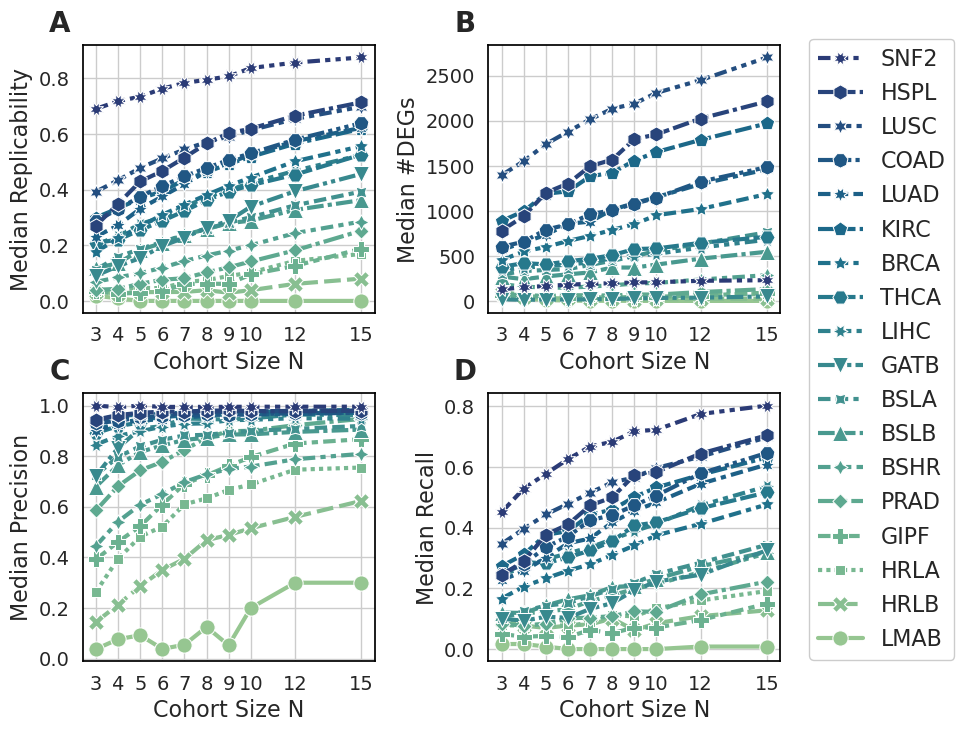

In [9]:
from matplotlib.ticker import MaxNLocator

def make4x4fig(c, suffix, metrics, deg_logscale=False):
    
    fig, axes = plt.subplots(2,len(metrics)//2, figsize=(4.5*len(metrics)//2,8), gridspec_kw={'hspace': 0.3,'wspace':0.39})
    axes = axes.flatten()
    
    all_N = sorted(set(c["N"]))
    c = c.sort_values(by=['Data'], key=lambda col: col.map({k: i for i, k in enumerate(order_rep)}))
    
    for i, (ax, met) in enumerate(zip(axes, metrics)):
    
        sns.lineplot(data=c, x="N", y=f"median_{met}{suffix}", hue="Data", style="Data", markers=True, ax=ax,lw=3,ms=11,palette=palette, hue_order=order_rep, style_order=order_rep)

        if i == 1 and deg_logscale: ax.set_yscale("log")
        ax.legend([],[], frameon=False)
        ax.set_ylabel(f"Median {pretty_met[met]}")
        ax.set_xlabel("Cohort Size N")
        #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_ticks(all_N)
        ax.set(xticks=(all_N))
        ax.annotate(chr(ord('A')+i), xy=(-0.08, 1.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)
    
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(0.92,0.5),framealpha=1,title=None,ncol=1,markerscale=1)
    return fig

dea = "DESeq2 Wald"
c = combined_all[~combined_all["isSynthetic"]]
c = c[(c["Out"]=="None") & (c["logFC"]==logFC) & (c["FDR"]==fdr) & (c["lfc_mode"] == lfc_mode) & (c["DEA"]==dea)]

fig = make4x4fig(c, suffix = "_method", metrics = ["rep","deg","prec","rec"])

figpath = f"../figures/fig2_metrics_vs_N.pdf"
#fig.tight_layout()
fig.savefig(figpath, bbox_inches="tight")
print(figpath)
print(f"Median replicability for N=3: {c[c['N']==3]['median_rep'].median():.2f}")
print(f"Median precision for N=3: {c[c['N']==3]['median_prec'].median():.2f}")
print(f"Median recall for N=3: {c[c['N']==3]['median_rec'].median():.2f}")
print(f"Median replicability for N=15: {c[c['N']==15]['median_rep'].median():.2f}")
print(f"Median precision for N=15: {c[c['N']==15]['median_prec'].median():.2f}")
print(f"Median recall for N=15: {c[c['N']==15]['median_rec'].median():.2f}")

In [ ]:
from matplotlib.ticker import MaxNLocator

c = combined_all

for logFC in [0,1]:
    for lfc_mode in ["post_hoc","formal"]:
        if logFC == 0 and lfc_mode == "formal": continue
        for dea in set(c["DEA"]):
            print(logFC, lfc_mode, dea)
            
            cc = c[(c["Out"]=="None") & (c["logFC"]==logFC) & (c["FDR"]==fdr) & (c["lfc_mode"] == lfc_mode) & (c["DEA"]==dea)]
        
            fig = make4x4fig(cc, suffix = "_method", metrics = ["rep","deg","prec","rec"])
        
            if logFC == 0 and lfc_mode == "formal":
                figpath = f"../figures/fig2_metrics_vs_N.lfc{logFC}.{lfc_mode}.pdf"
            else:
                figpath = f"../figures/sfig_metrics_vs_N.{dea.replace(' ','')}.lfc{logFC}.{lfc_mode}.pdf"
                
            fig.tight_layout()
            fig.savefig(figpath, bbox_inches="tight")
            print(figpath)
            print(f"Median precision for N=15: {cc[cc['N']==15]['median_prec'].median():.2f}")

In [ ]:
# At which N do we see >90% precision
cc=c[c["median_prec_method"]>0.95].sort_values(by="N")
cc[~cc["Data"].duplicated()]

cc=c[c["median_rec_method"]>0.5].sort_values(by="N")
cc[~cc["Data"].duplicated()]

# Figure 4: Enrichment

../figures/fig4_enrich_metrics_KEGG_vs_N.ashr.pdf
Median replicability for N=3: 0.11
Median precision for N=3: 0.71
Median recall for N=3: 0.22
Median replicability for N=15: 0.49
Median precision for N=15: 0.85
Median recall for N=15: 0.81


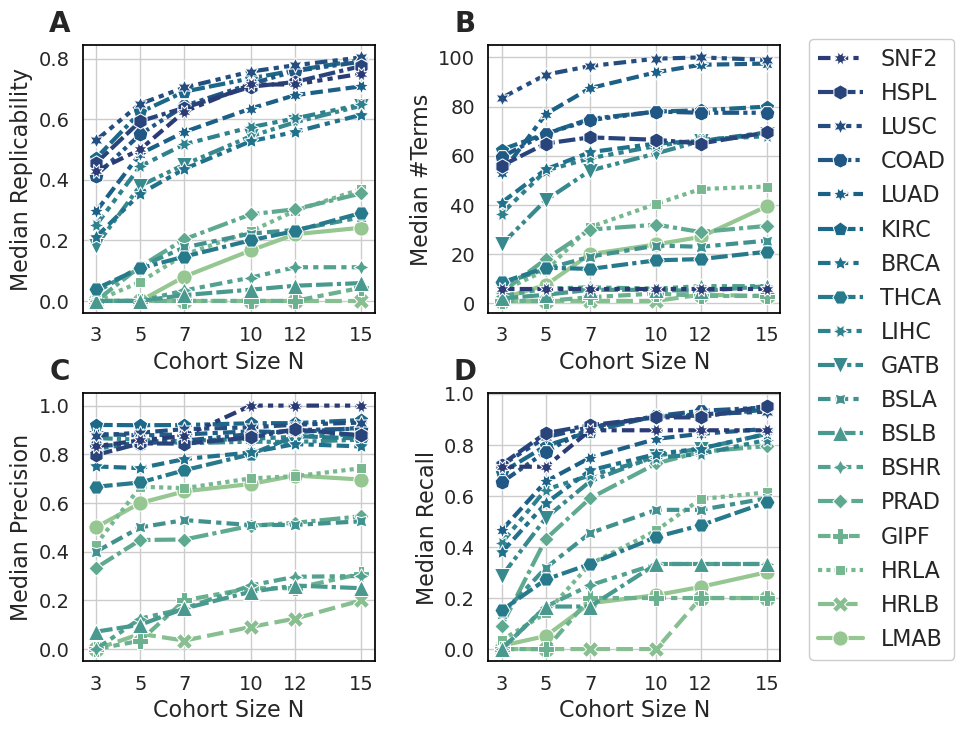

In [31]:
lib = "GO_Biological_Process"#_2023"
#lib = "KEGG"#_2021_Human"

dea = "DESeq2"
dea = "deseq2_ashr"
is_shrunk = "ashr" in dea

logFC = 1
lfc_mode = "formal"
fdr = 0.05

c = combined_gsea
c = c[(c["Out"]=="None") & (c["Library"]==lib) & (c["DEA"]==dea)]

fig = make4x4fig(c, suffix = "", metrics = ["rep","terms","prec","rec"])

figpath = f"../figures/fig4_enrich_metrics_{lib}_vs_N.{'ashr.' if is_shrunk else ''}pdf"
fig.savefig(figpath, bbox_inches="tight")
print(figpath)

print(f"Median replicability for N=3: {c[c['N']==3]['median_rep'].median():.2f}")
print(f"Median precision for N=3: {c[c['N']==3]['median_prec'].median():.2f}")
print(f"Median recall for N=3: {c[c['N']==3]['median_rec'].median():.2f}")
print(f"Median replicability for N=15: {c[c['N']==15]['median_rep'].median():.2f}")
print(f"Median precision for N=15: {c[c['N']==15]['median_prec'].median():.2f}")
print(f"Median recall for N=15: {c[c['N']==15]['median_rec'].median():.2f}")

# Figure 3: logFC

In [12]:
def get_iqr(sorted_ref, tab, cutoff, CI=0.5):
    x = range(len(sorted_ref))
    
    # not really a confidence interval
    up_lim = (1+CI)/2
    low_lim = (1-CI)/2
    cutoff = 1
    
    #std_lfc = tab.std(axis=1).loc[sorted_ref.index]
    up = tab.quantile(up_lim,axis=1).loc[sorted_ref.index]
    low = tab.quantile(low_lim,axis=1).loc[sorted_ref.index]
    
    crossing = sorted_ref[ ((up>-cutoff) & (low<-cutoff)) | ((up>cutoff) & (low<cutoff)) ]
    cross_ind = np.array(x)[sorted_ref.index.isin(crossing.index)]
    
    mean_pass_cutoff = sorted_ref[sorted_ref.abs()>cutoff]

    return up, low, crossing, cross_ind, mean_pass_cutoff

def lfc_rank_plot(N, sorted_ref,tab,ax,title,title2="",xlabel="",cutoff=1,CI=0.5,plot_crossings=False,plot_seconday=[],barcolor="grey",plot_ref=True):
    
    sf = sorted_ref
    sorted_ref = sorted_ref["logFC"]
    x = np.arange(len(sorted_ref))
    up, low, crossing, cross_ind, mean_pass_cutoff = get_iqr(sorted_ref, tab, cutoff=cutoff, CI=CI)

    if plot_ref:
        ax.scatter(x=x, data=sf,y="logFC",label=xlabel,zorder=101)
        ax.axhline(cutoff,ls="--",c="black",label=f"Threshold = {cutoff}",alpha=0.9,zorder=103)
        ax.axhline(-cutoff,ls="--",c="black",alpha=0.9,zorder=101)
    #ax.scatter(x=x[~sf["Sig"]], data=sf[~sf["Sig"]],y="logFC",label=xlabel+" NS")
    #ax.scatter(x=x[sf["Sig"]], data=sf[sf["Sig"]],y="logFC",label=xlabel+" DEG",marker="x")

    if plot_crossings:
        if len(x):
            ax.scatter(cross_ind, crossing, label=f"Crossings N{N}: {len(crossing)} ({len(crossing)/len(x):.2%})",zorder=102,s=0)

    if len(x):
        label = f"{CI:.0%} IQR N={N if N==15 else 3} | Crossings: {len(crossing)} ({len(crossing)/len(x):.2%})"
    else:
        label = f"{CI:.0%} IQR N={N if N==15 else 3} | No crossings"
    ax.fill_between(x, up, low, edgecolor="none",color=barcolor,alpha=0.5,label=label)
    #ax.fill_between(cross_ind, up.iloc[cross_ind], low.iloc[cross_ind], edgecolor="none",color="pink",alpha=0.5,label="Crossing")
    ax.set_xlabel("Gene Rank")
    ax.set_ylabel(r"log$_2$FC")
    ax.text(s=title2,x=0.5,y=0.9,ha="center",va="center",transform=ax.transAxes,bbox=boxprops)
    ax.legend(framealpha=1,title=f"{title}",title_fontsize=15,loc="lower left",ncol=plot_crossings+1)
    #ax.legend(framealpha=1,title=f"{title}\n|{xlabel}|>{cutoff} = {len(mean_pass_cutoff)}",title_fontsize=16)
    ax.grid(False)

120
120


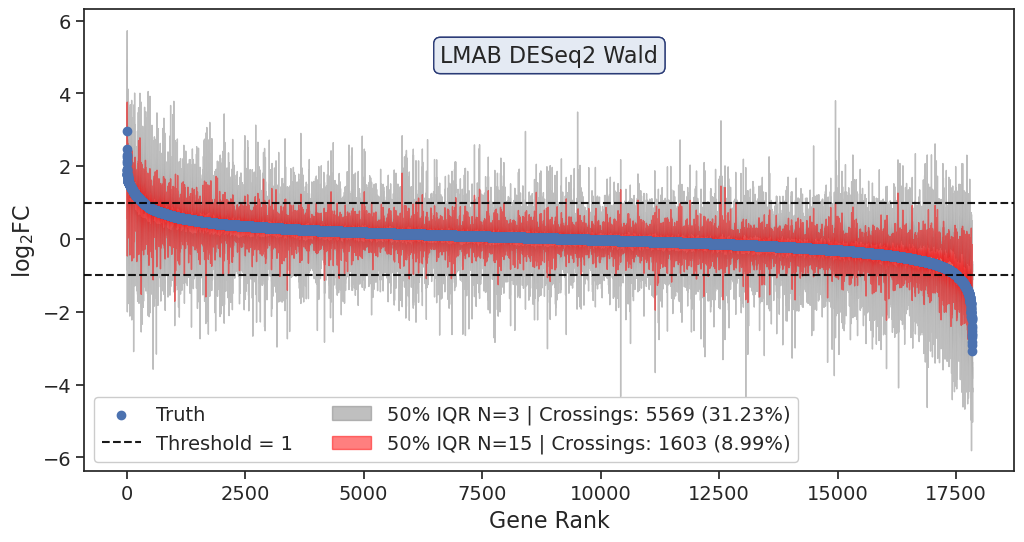

In [14]:
dea = "deseq2"
#dea = "deseq2_ashr"
out = "none"
Ns = [3,15]

site = "breast_lumab"
#site = "yeast"

scale = 0.6

#fig, axes = plt.subplots(2,1,figsize=(scale*20,scale*20), gridspec_kw={'hspace': 0.2,'wspace':0})

sites_plot_not = []#"yeast","breast_lumab"]
sites_plot =  {s for s in sites if s not in sites_plot_not}
sites_plot = ["breast_lumab"]
j=0
for i, site in enumerate(sites_plot):

    with sns.axes_style("ticks"):
        fig, ax = plt.subplots(1, 1, figsize=(scale*20,scale*10))

    data = sites[site]
    prdata_ = prdata[data] if data in prdata else data
    paramset = get_paramset(prdata_)

    for k, N in enumerate(Ns):
        p = f"../data/{site}/{data}/{data}_N{N}/all.logFC.{out}.{dea}.{paramset}"
        tab = open_table(p)
        
        p = f"../data/{site}/{data}/{data}_N{N}/all.FDR.{out}.{dea}.{paramset}"
        tab_fdr = open_table(p)
        
        p = f"../data/{site}/{data}/{data}.{dea}.lfc1.csv"
        truth = open_table(p)
        truth_sig = truth[truth["FDR"]<0.05]
        print(len(truth_sig))
    
        #sorted_ref = tab.median(axis=1).sort_values(ascending=False)
        sorted_ref = truth.sort_values(by="logFC", ascending=False)
        sorted_ref["Sig"] = False
        sorted_ref.loc[truth_sig.index,"Sig"] = True

        sorted_ref = sorted_ref.drop(["lfcSE"],axis=1)
        sorted_ref.dropna(inplace=True)
        tab = tab.loc[sorted_ref.index]

        plot_crossings = True
        title2 = rf"{prdata_} {prdea[dea]}"
        lfc_rank_plot(N, sorted_ref,tab,ax,title2=title2,title="",xlabel="Truth",cutoff=1,CI=0.5,barcolor="grey" if k==0 else "red", plot_ref=k==0, plot_crossings=plot_crossings)
    #ax.annotate(chr(ord('A')+i+1+j), xy=(-0.05, 1.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=28)
    j+=1

    if plot_crossings:
        handles, labels = ax.get_legend_handles_labels()
        # handles = np.array(handles)[[0,2,4,1,3,5]]
        # labels = np.array(labels)[[0,2,4,1,3,5]]
        # axes[i,1].legend(handles,labels,framealpha=1,loc="lower left",ncol=plot_crossings+1,fontsize=14)
        handles = np.array(handles)[[0,1,3,5]]
        labels = np.array(labels)[[0,1,3,5]]
        ax.legend(handles,labels,framealpha=1,loc="lower left",ncol=2,fontsize=14)#,prop={'family': 'monospace'})

    #fig.tight_layout()
    #figpath = f"../figures/fig3.iqr.png"
    #figpath = f"../figures/sfig.iqr.{prdata_}.png"
    #fig.savefig(figpath,dpi=fig.dpi * 2, bbox_inches="tight")
    #print(figpath)

289
289
120
120
../figures/fig3.iqr.png


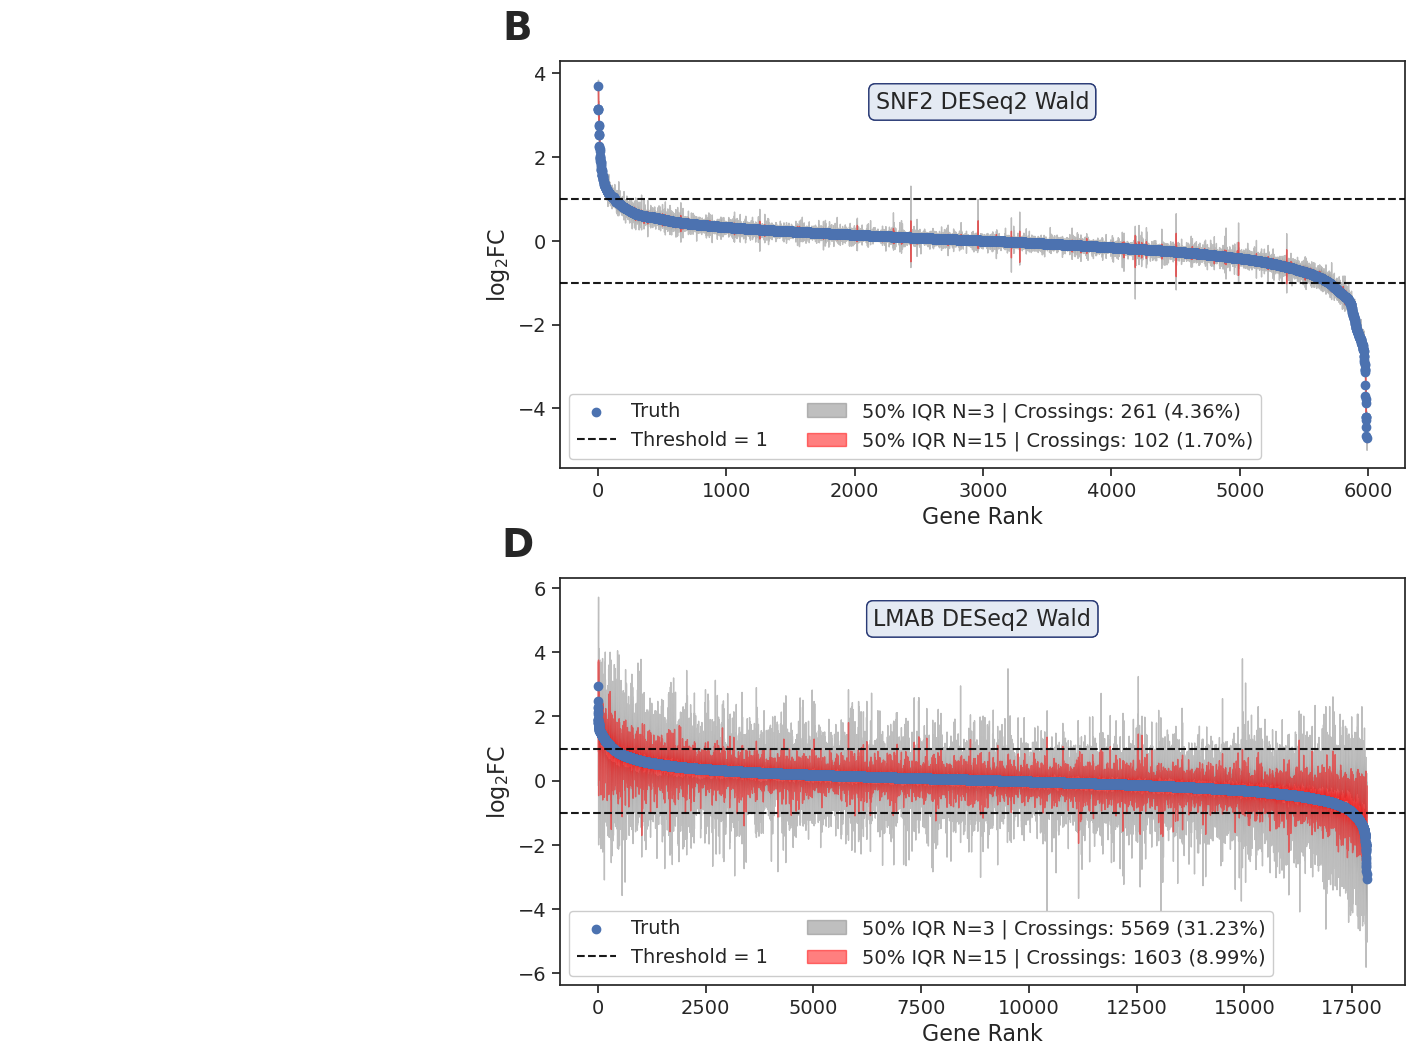

In [15]:
with sns.axes_style("ticks"):
    fig, axes = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 2], 'hspace': 0.27,'wspace':0.2}, figsize=(scale*30,scale*20))

sites_plot = ["yeast","breast_lumab"]
j=0
for i, (ax, site) in enumerate(zip(axes[:,1], sites_plot)):
    
    data = sites[site]
    prdata_ = prdata[data] if data in prdata else data
    paramset = get_paramset(prdata_)

    for k, N in enumerate(Ns):
        p = f"../data/{site}/{data}/{data}_N{N}/all.logFC.{out}.{dea}.{paramset}"
        tab = open_table(p)
        
        p = f"../data/{site}/{data}/{data}_N{N}/all.FDR.{out}.{dea}.{paramset}"
        tab_fdr = open_table(p)
        
        p = f"../data/{site}/{data}/{data}.{dea}.lfc1.csv"
        truth = open_table(p)
        truth_sig = truth[truth["FDR"]<0.05]
        print(len(truth_sig))
    
        #sorted_ref = tab.median(axis=1).sort_values(ascending=False)
        sorted_ref = truth.sort_values(by="logFC", ascending=False)
        sorted_ref["Sig"] = False
        sorted_ref.loc[truth_sig.index,"Sig"] = True
        
        sorted_ref.dropna(inplace=True)
        tab = tab.loc[sorted_ref.index]
        
        plot_crossings = True
        title2 = rf"{prdata_} {prdea[dea]}"
        lfc_rank_plot(N, sorted_ref,tab,ax,title2=title2,title="",xlabel="Truth",cutoff=1,CI=0.5,barcolor="grey" if k==0 else "red", plot_ref=k==0, plot_crossings=plot_crossings)
    ax.annotate(chr(ord('A')+i+1+j), xy=(-0.05, 1.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=28)
    j+=1

    if plot_crossings:
        handles, labels = axes[i,1].get_legend_handles_labels()
        # handles = np.array(handles)[[0,2,4,1,3,5]]
        # labels = np.array(labels)[[0,2,4,1,3,5]]
        # axes[i,1].legend(handles,labels,framealpha=1,loc="lower left",ncol=plot_crossings+1,fontsize=14)
        handles = np.array(handles)[[0,1,3,5]]
        labels = np.array(labels)[[0,1,3,5]]
        axes[i,1].legend(handles,labels,framealpha=1,loc="lower left",ncol=2,fontsize=14)#,prop={'family': 'monospace'})

    scndax = axes[0,0] if i == 0 else axes[1,0]
    # sns.kdeplot(ax=scndax,y=sorted_ref["logFC"])
    # sns.kdeplot(ax=scndax,y=tab.values.flatten(),color="grey",fill=True)
    # scndax.set(ylim=ax.get_ylim())
    scndax.set_axis_off()

#fig.tight_layout()
figpath = f"../figures/fig3.iqr.png"
#fig.savefig(figpath,dpi=fig.dpi * 2, bbox_inches="tight")
print(figpath)

In [30]:
from clustering import * 

def display_clustered_logCPM_heatmap_NT2(df, level=0, plot_dn=False, clustermap_kwargs=None):

    distmethod = "ward" #"average"
    vmin2, vmax2 = 0.7, 1
    vmin, vmax = 0.2, 1

    df_logCPM = find_logCPM(df, len(df), method="all", replacezeros=True)
    
    df_logCPM_corr = df_logCPM.corr()
    linkage = hierarchy.linkage(df_logCPM_corr, method=distmethod)
    
    replicates = df.shape[1]//2
    fclusters = hierarchy.fcluster(linkage, t=0.5, criterion="distance")

    copy_T2N = False
    copy_N2T = False

    if copy_T2N:
        # Copy the T clusters to N clusters
        T_clusters = fclusters[replicates:]
        NT_clusters = np.concatenate([T_clusters,T_clusters])
        cluster_labels = np.unique(NT_clusters)
    elif copy_N2T:
        # Copy the T clusters to N clusters
        N_clusters = fclusters[:replicates]
        NT_clusters = np.concatenate([N_clusters,N_clusters])
        cluster_labels = np.unique(NT_clusters)
    else:
        NT_clusters = fclusters
        
    dn = get_dendrogram(df_logCPM_corr,linkage,thresh=0.5,Plot=plot_dn, title='Hierarchical Clustering Dendrogram')
    row_colors_cl = sort_cluster_colors(dn)
    if copy_T2N: row_colors_cl = row_colors_cl[replicates:] + row_colors_cl[replicates:] # Copy T clusters to N samples
    elif copy_N2T: row_colors_cl = row_colors_cl[:replicates] + row_colors_cl[:replicates] # Copy N clusters to T samples
    col_colors_cl = ["blue" for _ in range(1,replicates+1)] + ["red" for _ in range(1,replicates+1)]
    g = sns.clustermap(df_logCPM_corr,row_cluster=1,row_linkage=linkage,col_linkage=linkage,
                       robust=True,row_colors=col_colors_cl, vmin=vmin2, vmax=vmax2, method=distmethod,
                      **clustermap_kwargs)
    g.ax_col_dendrogram.set_visible(False)
    return g, df_logCPM_corr


In [ ]:
from misc import replicate_sampler
from DEA import normalize_counts

for site in sites:
    #f site in ["yeast","breast_lumab"]: continue
    #if site not in ["pregnancy"]: continue
    if sites[site] not in prdata: continue
    try:
        df = pd.read_csv(f"../data/{site}/{sites[site]}/{sites[site]}.norm.csv", index_col=0)
    except FileNotFoundError:
        df = pd.read_csv(f"../data/{site}/{sites[site]}/{sites[site]}.csv", index_col=0)
        df = normalize_counts(df)
        df.to_csv(f"../data/{site}/{sites[site]}/{sites[site]}.norm.csv")

    print(site)
    g, df_logCPM_corr = display_clustered_logCPM_heatmap_NT2(df, 0.5, clustermap_kwargs={"yticklabels":False,"xticklabels":False})

    #g.ax_row_dendrogram.text(0.5, 1.14, "A" if site=="yeast" else "C", fontsize=57, weight="bold", ha="left", va="top", transform=g.ax_row_dendrogram.transAxes)
    g.ax_row_dendrogram.text(3.05, 1.02, prdata[sites[site]], fontsize=42, ha="center", va="bottom", transform=g.ax_row_dendrogram.transAxes)
    
    #g.cax.set_visible(False)
    g.savefig(f"../figures/heat.{prdata[sites[site]]}.png")
    #break    

# Figure 5: Bootstrap

In [18]:
# We'll store computed Pearson statistics in a dict

pearson_dict_fname = "../data/multi/pearson_dict.txt"
if os.path.isfile(pearson_dict_fname):
    with open(pearson_dict_fname, "rb") as f:
        pearson_dict = pickle.load(f)
    print("Loaded dict")
else:
    pearson_dict = dict()

Loaded dict


Figsize (8.928, 13.64)
../figures/boot.vs.3metrics.Spear..pdf


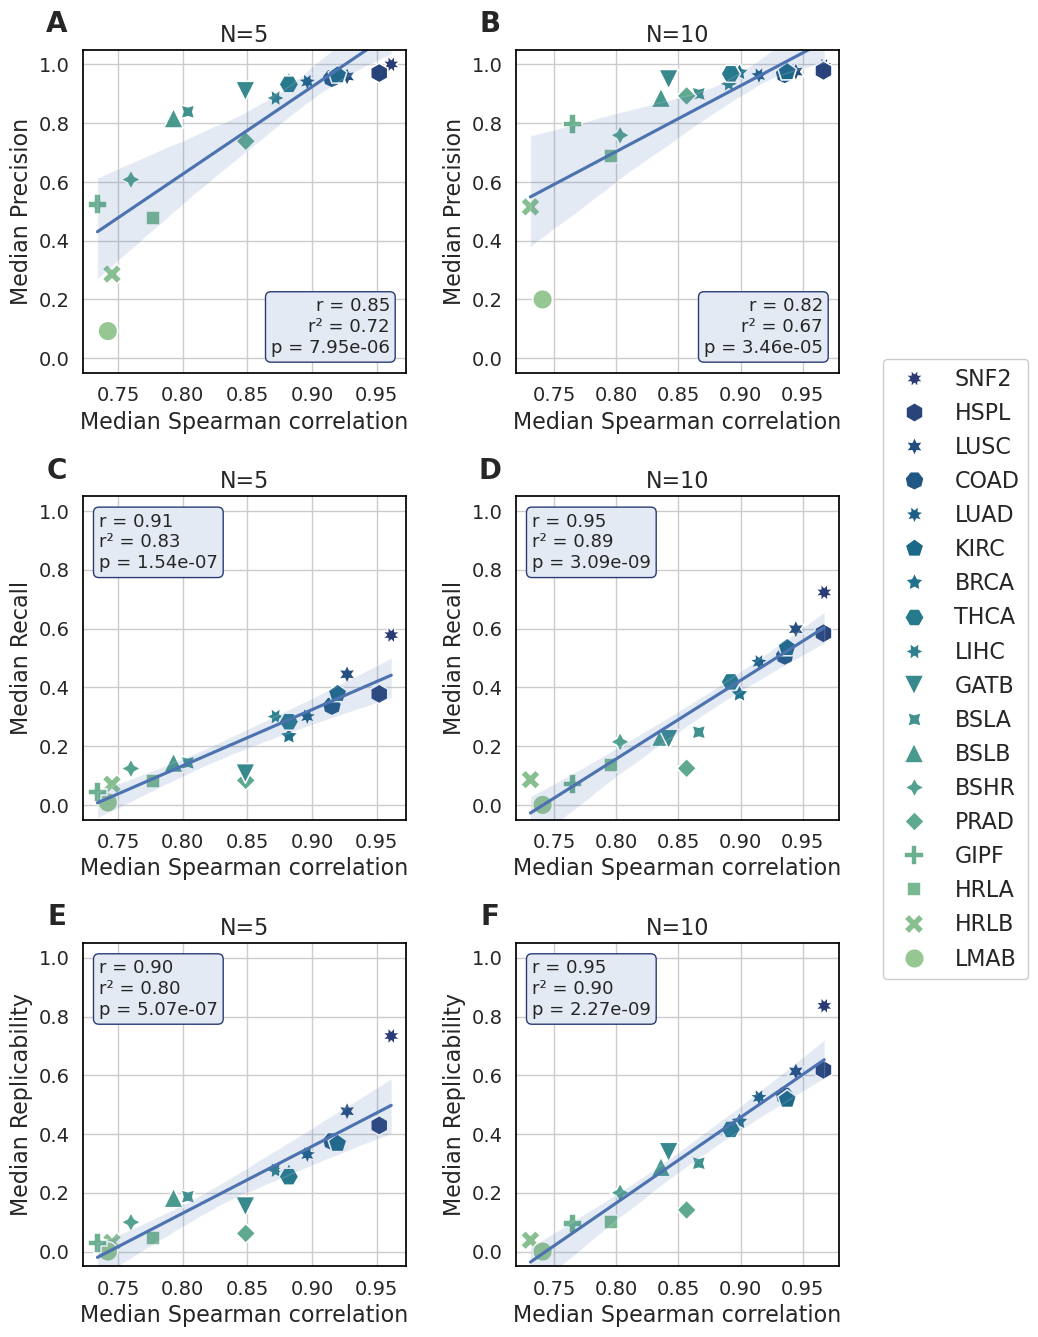

In [21]:
import scipy.stats as stats

cohorts = range(50)
reference = "Cohort"
metric_suffix = f"median"
metric_prefix = "Spear" # KL, Spear

suffix = "" # for DEGs
# suffix = "_KEGG"
# suffix = "_GO"

fit_prec = "linear"
#fit_prec = "binormal"

if metric_prefix == "KL": fit_prec = "linear"

y_prefixes = ["Prec", "Rec", "Rep"]
x1 = f"{metric_prefix}_{reference}_N5_{metric_suffix}"
x2 = f"{metric_prefix}_{reference}_N10_{metric_suffix}"
y1_suffix = f"N5{suffix}"
y2_suffix = f"N10{suffix}"

def bootstrap_plot(metric_prefix,metric_suffix,x1,x2,y1_suffix,y2_suffix, y_prefixes, N1=5, N2=10):

    all_N = {N1: (x1,y1_suffix),
             N2: (x2,y2_suffix)
            }
    
    scale=1.24
    figsize = (scale*7.2,scale*(-1+4*len(y_prefixes)))
    print("Figsize",figsize)
    fig, axes = plt.subplots(len(y_prefixes), 2, figsize=figsize,sharex=False,sharey=False)
    
    for ax,  y_prefix in zip(axes, y_prefixes):
        ax = ax.flatten()
    
        sns.scatterplot(data=dfm, y=f"{y_prefix}_{y1_suffix}", x=x1, hue=dfm.index, style=dfm.index, hue_order=order_rep, style_order=order_rep, s=200, ax=ax[0], palette=palette)
        sns.scatterplot(data=dfm, y=f"{y_prefix}_{y2_suffix}", x=x2, hue=dfm.index, hue_order=order_rep, style_order=order_rep, style=dfm.index, s=200, ax=ax[1], palette=palette)
    
        if fit_prec == "linear":
            sns.regplot(data=dfm, y=f"{y_prefix}_{y1_suffix}", x=x1, ax=ax[0], scatter_kws={'s':0}, order=1)
            sns.regplot(data=dfm, y=f"{y_prefix}_{y2_suffix}", x=x2, scatter_kws={'s':0}, ax=ax[1], order=1)
    
    
    
        for N, a in zip(all_N, ax):
            xx = all_N[N][0]
            yy = f"{y_prefix}_{all_N[N][1]}"
            x = dfm[xx].dropna()
            y = dfm[yy].dropna()
            common = x.index.intersection(y.index)
            x, y = x.loc[common], y.loc[common]
        
            if fit_prec == "binormal":
                def binormal(x, a, b):
                    return stats.norm.cdf(a * stats.norm.ppf(x) + b)
            
                p0 = [3,-2] # this is an mandatory initial guess
                params, pcov = curve_fit(binormal, x, y, p0=p0, bounds=(-2.9, np.inf))
                sigma_ab = np.sqrt(np.diagonal(pcov))
                print(params)
                xlin = np.linspace(0.7,1,100)
                y_binormal = binormal(xlin, *params)
                sns.lineplot(x=xlin, y=y_binormal, color="#4d72b0",lw=2,zorder=99,ax=a)
                bound_upper = binormal(xlin, *(params + sigma_ab))
                bound_lower = binormal(xlin, *(params - sigma_ab))
                a.fill_between(xlin, bound_lower, bound_upper,
                             color = '#e4eaf3', alpha = 1, zorder=0)
        
            else:
                r_val, p_val = stats.pearsonr(x,y)
                pearson_dict[(xx,yy)] = (r_val, p_val)
                r2_val = r_val ** 2
    
                if y_prefix == "Prec":
                    loc = (0.95, 0.05)
                    ha = "right"
                    va = "bottom"
                else:
                    loc = (0.05,0.95)
                    ha="left"
                    va="top"
                a.text(loc[0], loc[1], f"r = {r_val:.2f}\nr² = {r2_val:.2f}\np = {p_val:.2e}", 
                       transform=a.transAxes, fontsize=13, va=va,ha=ha, bbox=boxprops)
    
            a.set(ylabel=f"Median {pretty_met[y_prefix]}")
        
    
    ### MISC.
    
    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles[::-1], labels[::-1], loc='center left', 
               bbox_to_anchor=(1,0.5),framealpha=1,title=None,ncol=1,markerscale=1)
    
    for i, a in enumerate(axes.flatten()):
        a.legend().remove()
        a.set_box_aspect(1)
        a.set(xlabel=(f"{metric_suffix.split('_')[-1].capitalize()} {pretty_met[metric_prefix]}"))
        a.set(ylim=(-0.05,1.05))
        if "Spear" in x1:
            pass
            a.xaxis.set_ticks(np.arange(0.75, 1, 0.05))
        a.annotate(chr(ord('A')+i), xy=(-0.08, 1.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)
        a.set_title(f"N={N1}" if i%2==0 else f"N={N2}", size=16)

    return fig
    
fig = bootstrap_plot(metric_prefix,metric_suffix,x1,x2,y1_suffix,y2_suffix, y_prefixes, N1=5, N2=10)

#fig.suptitle(f"25 Bootstrap trials | {len(cohorts)} Cohorts | {suffix}")
fig.tight_layout()
figpath = f"../figures/boot.vs.{len(y_prefixes)}metrics.{metric_prefix}.{suffix}.pdf"
fig.savefig(figpath, bbox_inches="tight")
print(figpath)

## Sup. Figure: non-bootstrapped statistics

Here, we show that non-bootstrapped statistics such as logFC std and number of DEGs cannot predict the performance metrics as reliably as the bootstrapped Spearman correlation.

In [52]:
Ns = [5,10]
stds = {N: dict() for N in Ns}
kurts = {N: dict() for N in Ns}
degs = {N: dict() for N in Ns}

for N in Ns:
    for data in datasets:
        p = datasets[data]["outpath"]
        name = prdata[data] if data in prdata else data
        ps = get_paramset(name)

        # logFC std
        pp = f"{p}/{data}_N{N}/all.logFC.none.deseq2.{ps}.feather"
        tab = open_table(pp)
        std = tab.std(axis=0).median()
        stds[N][name] = std

        # logFC kurtosis
        k = tab.kurtosis(axis=0).median()
        kurts[N][name] = k

        # Number of DEGS
        pp = f"{p}/{data}_N{N}/all.FDR.none.deseq2.{ps}.feather"
        tab = open_table(pp)
        deg = (tab<0.05).sum().median()
        degs[N][name] = deg

Figsize (8.928, 13.64)
../figures/non-boot.vs.3metrics.std..pdf


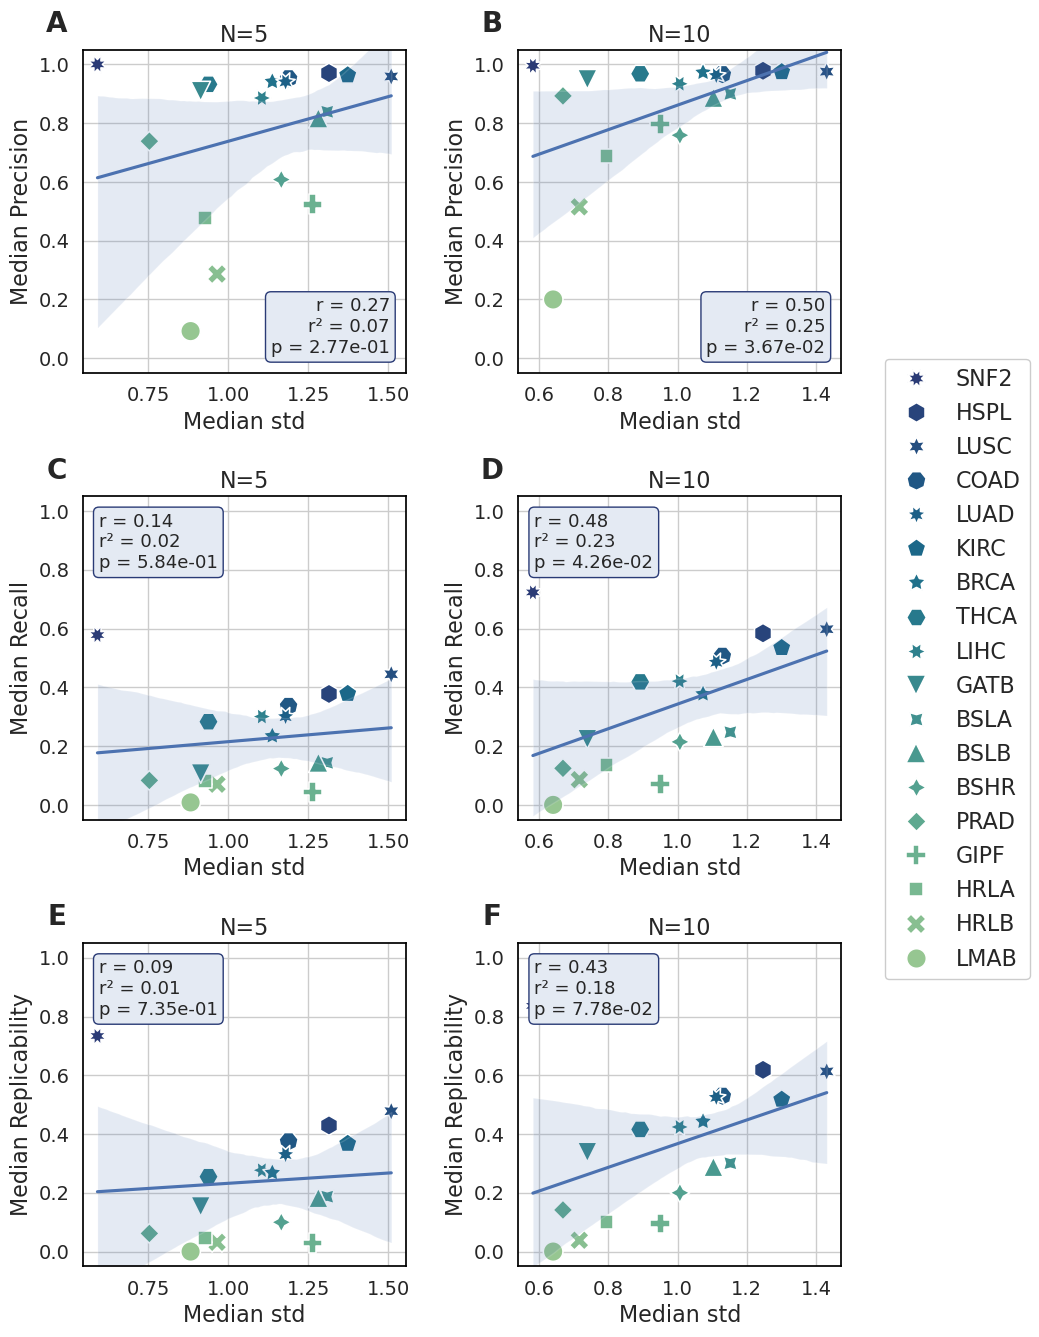

In [58]:
for N in Ns:
    dfm[f"std_N{N}"] = stds[N]
    dfm[f"kurt_N{N}"] = kurts[N]
    dfm[f"deg_N{N}"] = degs[N]

y_prefixes = ['Prec', 'Rec', 'Rep']
metric_prefix = "deg" # "std", "kurt", "deg"
metric_suffix = "median"

suffix = "" # for DEGs
#suffix = "_KEGG"
#suffix = "_GO"

x1 = f"{metric_prefix}_N5"
x2 = f"{metric_prefix}_N10"

y1_suffix = f"N5{suffix}"
y2_suffix = f"N10{suffix}"

fig = bootstrap_plot(metric_prefix,metric_suffix,x1,x2,y1_suffix,y2_suffix, y_prefixes, N1=5, N2=10)

fig.tight_layout()
figpath = f"../figures/non-boot.vs.{len(y_prefixes)}metrics.{metric_prefix}.{suffix}.pdf"
fig.savefig(figpath, bbox_inches="tight")
print(figpath)

## Predictor comparisons

In [80]:
#pickler(pearson_dict, pearson_dict_fname)

pdf = pd.DataFrame(pearson_dict, index=["r","p"]).T.reset_index(names=["Predictor","Metric"])
pdf["N"] = pdf["Predictor"].str.split("_N", expand=True)[1].str.split("_", expand=True)[0].astype(int)
pdf["Target"] = pdf["Metric"].apply(lambda x: "GO" if "GO" in x else "KEGG" if "KEGG" in x else "DEG")
pdf["Metric"] = pdf["Metric"].apply(lambda x: "Precision" if "Prec" in x else "Recall" if "Rec" in x else "Replicability")
pdf["Predictor"] = pdf["Predictor"].apply(lambda x: "Spearman" if "Spear" in x else "#DEG" if "deg" in x else "logFC std")
pdf["Metric"] = pdf["Metric"].replace({"Replicability":"Repl."})

order = ["Spearman","#DEG","logFC std"]
pdf.sort_values(by="Predictor", key=lambda x: x.map(lambda e: order.index(e)), inplace=True)
pdf.head()

,Predictor,Metric,r,p,N,Target
0,Spearman,Precision,0.811409,4.368803e-05,5,KEGG
1,Spearman,Precision,0.772439,1.719697e-04,10,KEGG
2,Spearman,Recall,0.946319,2.927760e-09,5,KEGG
3,Spearman,Recall,0.912964,1.256509e-07,10,KEGG
4,Spearman,Repl.,0.902826,2.935992e-07,5,KEGG


/scratch/local/17348425/ipykernel_1627528/2918485197.py:19: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  bars = sns.barplot(data=pdff, x="Metric", y="r", ax=ax,hue="Predictor",palette=npg)
/scratch/local/17348425/ipykernel_1627528/2918485197.py:19: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  bars = sns.barplot(data=pdff, x="Metric", y="r", ax=ax,hue="Predictor",palette=npg)
/scratch/local/17348425/ipykernel_1627528/2918485197.py:19: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  bars = sns.barplot(data=pdff, x="Metric", y="r", ax=ax,hue="Predictor",palette=npg)
/scratch/local/17348425/ipykernel_1627528/2918485197.py:19: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  bars = sns.barplot(data=pdff, x="Metric", y="r", ax=ax,hue="Predictor",palette=npg)
/scratch/local/17348425/ipykernel_16

../figures/sfig20_pred_metric_comparison.pdf


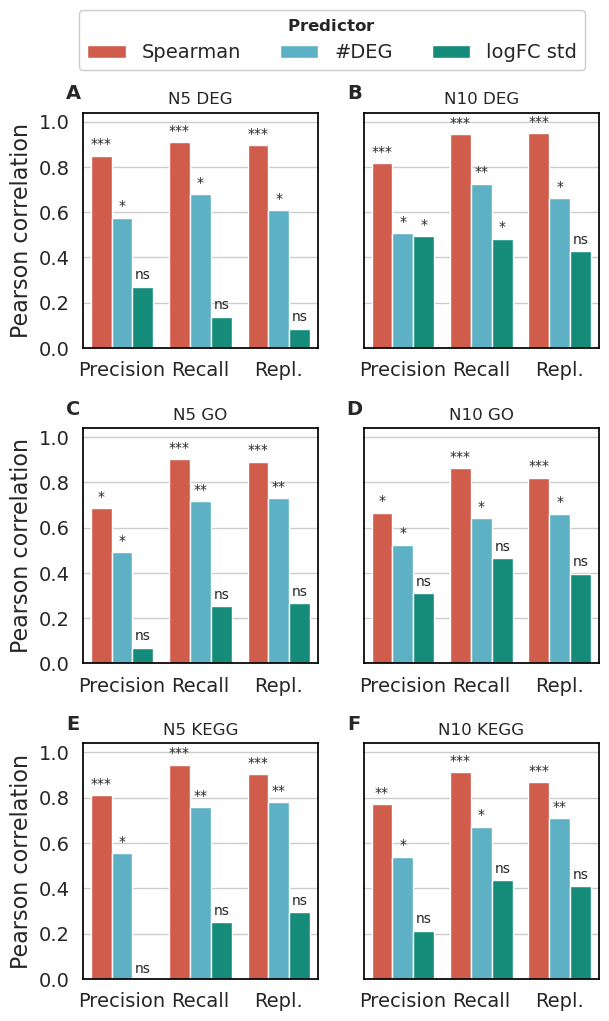

In [81]:
scale = 1.25
fig, axes = plt.subplots(3,2,figsize=(scale*5.8,scale*9),sharey=True,sharex=False,gridspec_kw={'wspace': 0.,'hspace':0.34})

def print_pval(pval):
    if pval > 0.05:
        return "ns"
    elif pval > 0.001:
        return "*"
    elif pval > 0.0001:
        return "**"
    else:
        return "***"

for ax_row, target in zip(axes, ["DEG","GO","KEGG"]):
            
    for ax, N in zip(ax_row, [5,10]):

        pdff = pdf[(pdf["N"]==N)&(pdf["Target"]==target)]
        bars = sns.barplot(data=pdff, x="Metric", y="r", ax=ax,hue="Predictor",palette=npg)
        ax.set_title(f"N{N} {target}")

        x_labels = [t.get_text() for t in ax.get_xticklabels()]*3
        x_labels = np.array(x_labels).flatten()
        bars_sorted = bars.patches#sorted([b for b in bars.patches if b.get_width()>0], key = lambda x: x.get_x())
        for bar,label,predictor in zip(bars_sorted, x_labels, pdff["Predictor"]):
            pval = pdff[(pdff["Metric"]==label) & (pdff["Predictor"]==predictor)]["p"].iloc[0]
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X position: Center of bar
                bar.get_height() + 0.02,            # Y position: Just above bar
                print_pval(pval),               # Custom text (e.g., "Metric: Value")
                ha='center', va='bottom', fontsize=10,zorder=99
            )
            
for i, a in enumerate(axes.flatten()):
    a.legend().remove()
    a.set_box_aspect(1)
    a.set_xticks(a.get_xticks())
    a.set(xlabel=None)
    #a.set_xticklabels(a.get_xticklabels(), rotation=5, ha='right')
    #a.get_xaxis().set_visible(False)
    a.set(ylim=(0,1.04))

    if i%2==0:
        a.set(ylabel="Pearson correlation")
    a.annotate(chr(ord('A')+i), xy=(-0.04, 1.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=14)

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', title=r"$\bf{Predictor}$",
           bbox_to_anchor=(0.5,0.98),framealpha=1,ncol=3,markerscale=1,fontsize=14)
    
fig.tight_layout()

figpath = f"../figures/sfig20_pred_metric_comparison.pdf"
fig.savefig(figpath, bbox_inches="tight")
print(figpath)

# Sup. Figure 1: Ground truth size

In [22]:
#datasetsfile = "../data/multi/datasets_wilcox.txt"
gsea_datasetsfile = f"../data/multi/gsea_datasets.deseq2.txt"

with open(gsea_datasetsfile, "rb") as f:
    gsea_datasets = pickle.load(f)
    gsea_datasets = {k:datasets[k] for k in sites.values()}

gsea_datasets.keys()

dict_keys(['LIHC', 'THCA', 'LUAD', 'LUSC', 'KIRC', 'COAD', 'BRCA', 'PRAD', 'LWPL', 'SNF2', 'GIPF', 'BASHER', 'BASLUMA', 'BASLUMB', 'HERLUMA', 'HERLUMB', 'LUMAB', 'HSPL'])

In [23]:
### DEGs

FDRs, logFCs = [0.05], [0,1, "post hoc"]
DEAs = ["edgerqlf", "edgerlrt", "deseq2"]#, "wilcox"]

iterables = [datasets,[prdea[d] for d in DEAs],FDRs,logFCs]
multi_cols = pd.MultiIndex.from_product(iterables, names=["Data","DEA","FDR","logFC"])
gt = pd.DataFrame(columns=multi_cols)
for data in datasets:
    for dea in DEAs:
        for fdr in FDRs:
            for lfc in logFCs:
                col = (data,prdea[dea],fdr,lfc)
                if lfc == "post hoc":
                    gt.loc[0,col] = datasets[data]["truth_stats"][0][fdr][1][dea]
                elif dea != "wilcox":
                    gt.loc[0,col] = datasets[data]["truth_stats"][lfc][fdr][lfc][dea]
                        
                        
gt=gt.unstack().reset_index(level=["Data","DEA","FDR","logFC"], drop=False)
gt.sort_values(by="DEA", inplace=True)
gt.rename(columns={0: "#DEG"}, inplace=True)

# Jaccard
iterables = [datasets,FDRs,logFCs]
multi_cols = pd.MultiIndex.from_product(iterables, names=["Data","FDR","logFC"])
gtj = pd.DataFrame(columns=multi_cols)

for data in datasets:
    for fdr in FDRs:
        for lfc in logFCs:
            col = (data,fdr,lfc)
            if lfc == "post hoc":
                gtj.loc[0,col] = datasets[data]["truth_stats"][0][fdr][1]["jaccard"]
            else:
                gtj.loc[0,col] = datasets[data]["truth_stats"][lfc][fdr][lfc]["jaccard"]
                    
gtj=gtj.unstack().reset_index(level=["Data","FDR","logFC"], drop=False)
gtj.rename(columns={0: "Jaccard"}, inplace=True)

gt["#DEG"] = gt["#DEG"].astype(float)
gtj["Jaccard"] = gtj["Jaccard"].astype(float)
df = gt
gtj.index = range(len(gtj))
df.index = range(len(df))
df["Data"].replace(prdata, inplace=True)

### Enrichment

libraries_yeast = ["KEGG_2019","GO_Biological_Process_2018"]
libraries_human = ["KEGG_2021_Human","GO_Biological_Process_2023"]
libraries = ["KEGG","GO_Biological_Process"]

iterables = [datasets, libraries]
multi_cols = pd.MultiIndex.from_product(iterables, names=["Data","Library"])
gtgsea = pd.DataFrame(columns=multi_cols)
for data in gsea_datasets:
    for lib in libraries:
        if data == "SNF2" and lib == "KEGG": libname = "KEGG_2019"
        if data != "SNF2" and lib == "KEGG": libname = "KEGG_2021_Human"
        if data == "SNF2" and lib == "GO_Biological_Process": libname = "GO_Biological_Process_2018"
        if data != "SNF2" and lib == "GO_Biological_Process": libname = "GO_Biological_Process_2023"
        col = (data,lib)
        site = gsea_datasets[data]["site"]
        tab = open_table(f"../data/{site}/{data}/gsea/gseapy.logFC.{libname}.deseq2_ashr.feather")["FDR"]
        gtgsea.loc[0,col] = (tab<0.05).sum()

gtgsea
gtgsea = gtgsea.unstack().reset_index(level=["Data","Library"], drop=False)
gtgsea.rename(columns={0: "#Terms"}, inplace=True)
gtgsea["Data"].replace(prdata, inplace=True)

In [24]:
order = df[df["logFC"]==1].groupby("Data")["#DEG"].mean().sort_values().index

def kf(x):
    try:
        return np.where(order==x)[0][0] # sort by data
    except IndexError:
        pass
        #return x # sort by DEA
    
df = df.sort_values(by=['Data',"DEA"], key=lambda col: col.map(kf))
gtj = gtj.sort_values(by='Data', key=lambda col: col.map(kf))
gtgsea = gtgsea.sort_values(by='Data', key=lambda col: col.map(kf))

combined_all = combined_all.merge(df[["Data", "DEA", "logFC","FDR", "#DEG"]], on=["Data", "DEA", "logFC","FDR"], how="left")
combined_all.rename({"#DEG":"Truth_DEGs"},inplace=True,axis=1)

0.8697976302541631


/scratch/local/17348425/ipykernel_1627528/1731391638.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='center')
/scratch/local/17348425/ipykernel_1627528/1731391638.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='center')
/scratch/local/17348425/ipykernel_1627528/1731391638.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='center')
/scratch/local/17348425/ipykernel_1627528/1731391638.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotati

../figures/sfig1_ground_truth_size.pdf


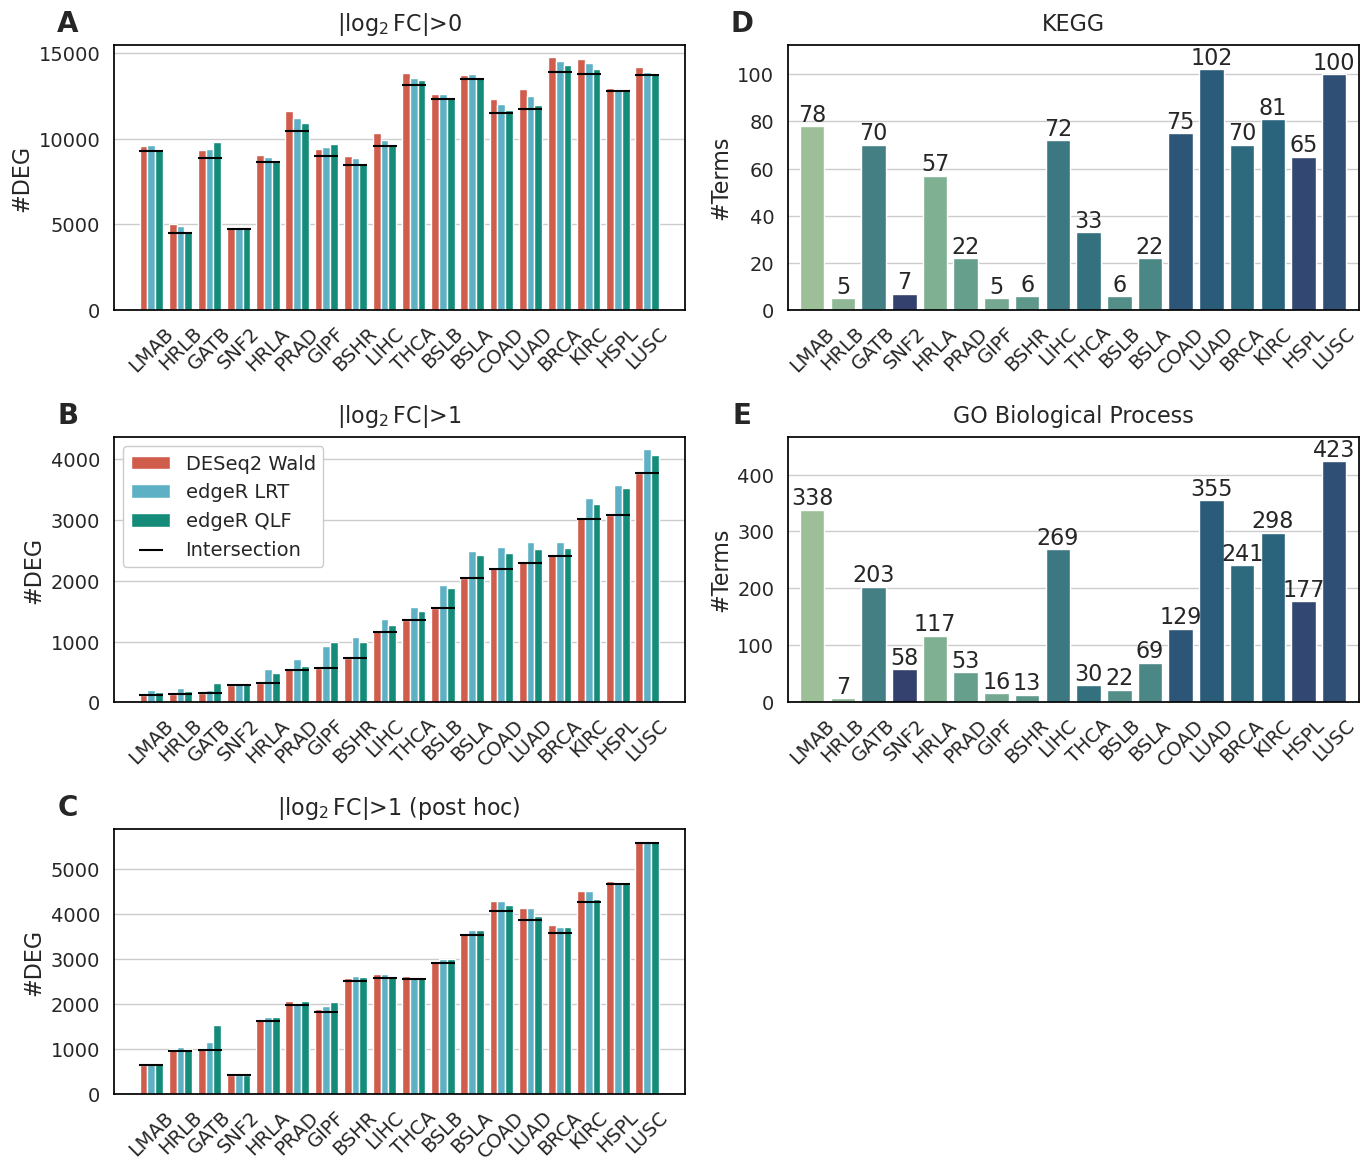

In [110]:
plt.rcParams['legend.title_fontsize'] = '15'

fig, ax = plt.subplots(3,2,figsize=(14,12), sharey=False)
ax = ax.T.flatten()

palette_npg = list(np.array(npg)[[0,1,2]])

####### DEGs #######

for i, lfc in enumerate([0,1,"post hoc"]):
    dfa=df[df["logFC"]==lfc]
    sns.barplot(data=dfa,x="Data",y="#DEG",hue="DEA", ax=ax[i],palette=palette_npg)

# intersection
jaccards = []
prdata_inv = {v:k for k,v in prdata.items()}
for i,data in enumerate(order):
    for logFC, a in zip([0,1,"post hoc"],ax[:3]):
        if logFC == "post hoc":
            logFC, logFC_test = 1, 0
        else:
            logFC_test = logFC
        d = data if data not in prdata_inv else prdata_inv[data]
        inter=datasets[d]["truth_stats"][logFC_test][0.05][logFC]["inter"]
        jaccard=datasets[d]["truth_stats"][logFC_test][0.05][logFC]["jaccard"]
        jaccards.append(jaccard)
        a.scatter(i,inter,marker="_",zorder=99,color="black",s=300,label="Intersection" if i < 1 and logFC < 1 else "")
print(np.mean(jaccards))
    
ax[0].set_title(r"$|\log_2\mathrm{FC}$|>0",size=16, pad=10)
ax[1].set_title(r"$|\log_2\mathrm{FC}$|>1",size=16, pad=10)
ax[2].set_title(r"$|\log_2\mathrm{FC}$|>1 (post hoc)",size=16, pad=10)


handles, labels = ax[0].get_legend_handles_labels()
labels = [l + " Wald" if l == "DESeq2" else l for l in labels]
ax[1].legend(handles, labels, loc='upper left',framealpha=1,fontsize=14)
#ax[0].text(0.01,0.825,r"$|\log_2\mathrm{FC}$|>0", transform=ax[0].transAxes, ha="left")
#ax[1].text(0.01,0.825,r"$|\log_2\mathrm{FC}$|>1", transform=ax[1].transAxes, ha="left")


####### Enrichment #######
for i, lib in enumerate(["KEGG","GO_Biological_Process"]):
    i+=3
    dfa = gtgsea[gtgsea["Library"] == lib].dropna()
    assert "SNF2" not in dfa["Data"]
    sns.barplot(data=dfa, x="Data", y="#Terms", ax=ax[i], palette=palette_ordered)
    for k in ax[i].containers:
        ax[i].bar_label(k,)
    ax[i].set_title(f"{lib.replace('_',' ')}",size=16, pad=10)
    xlim = ax[i].get_xlim()
    ylim = ax[i].get_ylim()
    ax[i].set(xlim=(xlim[0]-0.3,xlim[1]+0.3), ylim=(ylim[0],1.05*ylim[1]))

####### Tidy up #######

for i, a in enumerate(ax[:-1]):
    if i !=1: a.legend([],[], frameon=False)
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='center')
    a.set(xlabel=None)
    a.annotate(chr(ord('A')+i), xy=(-0.08, 1.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)
ax[-1].set_axis_off()

figpath = f"../figures/sfig1_ground_truth_size.pdf"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

# Supp. Fig 2: Methods comparison

In [25]:
from urn import random_jacc_rep

combined_all["genes"] = combined_all["Data"].replace({prdata[d] if d in prdata else d: int(datasets[d]["genes"]) for d in datasets})
combined_all["rep_rnd"] = combined_all["genes"].apply(random_jacc_rep)
combined_all["rep_rnd"] = (combined_all["median_deg_method"] / combined_all["genes"]).apply(random_jacc_rep)


from urn import E_nc_hyp
def random_metrics(A, N, m1, w=1):
    """MCC, precision, recall of randomly sampled subsets of size A out of N, given ground truth of size m1, and ground truth bias w (odds ratio)"""
    TP = E_nc_hyp(A, N, m1, w=w, method="wallenius")
    FP = A - TP
    FN = m1 - TP
    TN = N - TP - FP - FN
    prec = TP / (TP + FP) if TP + FP else np.nan
    rec = TP / (TP + FN) if TP + FN else np.nan
    squared = float((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    mcc = (TP * TN - FP * FN) / (np.sqrt(squared)) if squared else np.nan
    return float(mcc), float(prec), float(rec)
    
    
combined_all["Truth_DEGs"] # value computed in Sup. Figure 1

combined_all[["mcc_rnd", "prec_rnd", "rec_rnd"]] = combined_all.apply(lambda row: pd.Series(random_metrics(row["median_deg_method"], row["genes"], row["Truth_DEGs"])), axis=1, result_type="expand")

/scratch/local/17397446/ipykernel_209521/1424961063.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  squared = float((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
/scratch/local/17397446/ipykernel_209521/1424961063.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(mcc), float(prec), float(rec)


In [ ]:
c = combined_all
c = c[(c["N"]==3) & (c["logFC"]==1)& (c["lfc_mode"]=="formal")]

c = c[[col for col in c.columns if col in ["Data","DEA", "median_prec_method","median_rec_method"]]]
c.sort_values(by="Data")

../figures/sfig2_methods_comparison.pdf


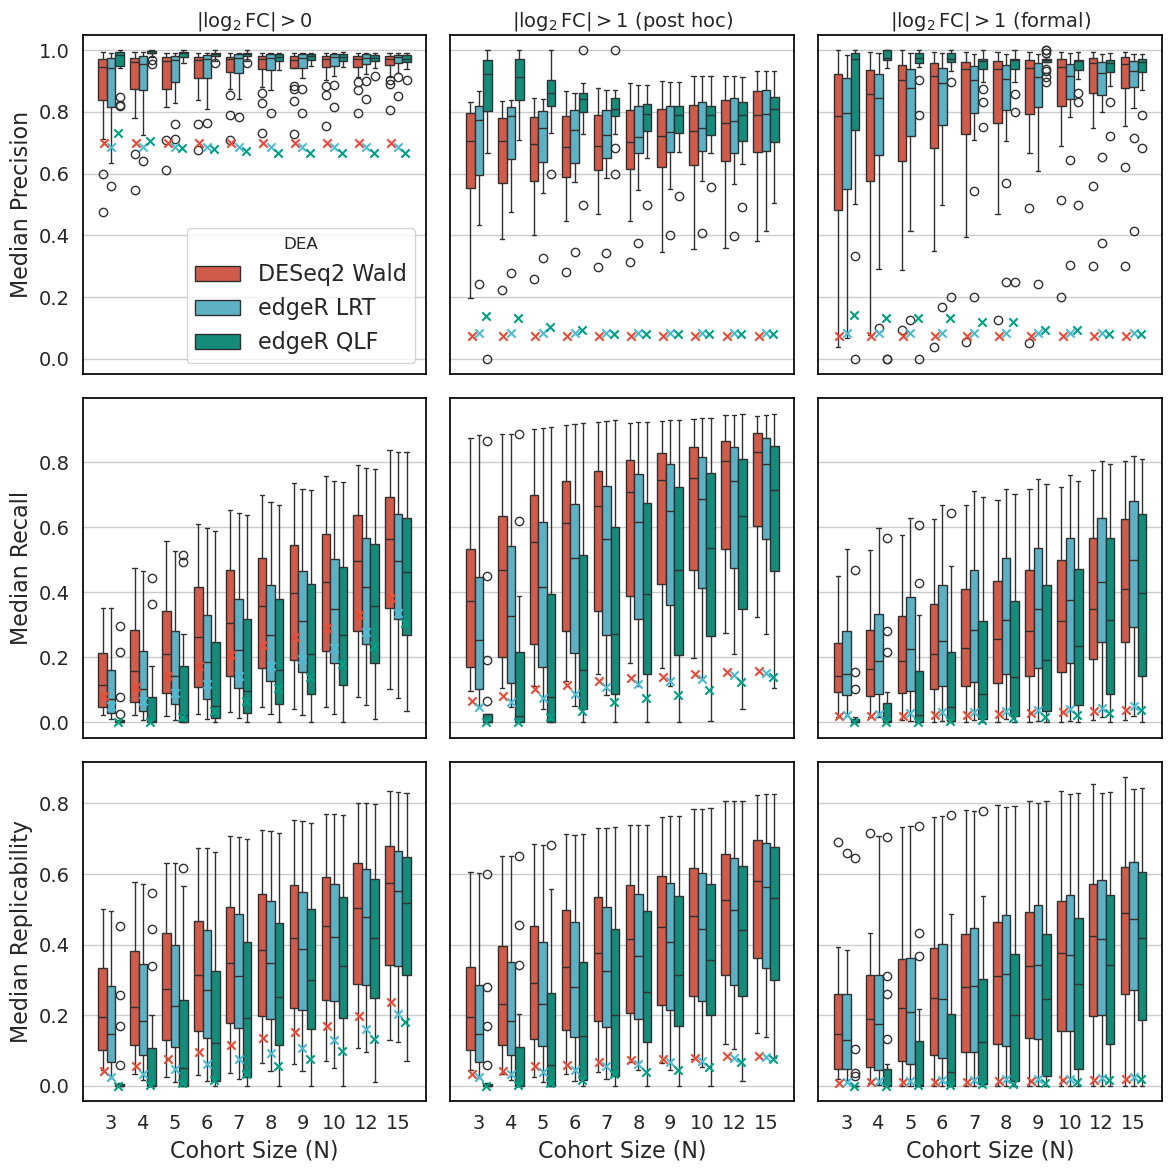

In [45]:
fig, axes = plt.subplots(3,3,figsize=(12,12),sharex=True,sharey="row")
axes=axes.flatten()
i=0
df_a = combined_all#[combined_all["Data"]=="SNF2"]

for metric in ["prec","rec","rep"]:
    for logFC in [0,"post",1]:
        ax = axes[i]
        if logFC==0:
            df = df_a[(df_a["logFC"]==0) & (df_a["lfc_mode"]=="post_hoc")]
            title = r"$|\log_2\mathrm{FC}|>0$"            
        elif logFC==1:
            df = df_a[(df_a["logFC"]==1) & (df_a["lfc_mode"]=="formal")]
            title = r"$|\log_2\mathrm{FC}|>1$ (formal)"
        elif logFC=="post":
            df = df_a[(df_a["logFC"]==1) & (df_a["lfc_mode"]=="post_hoc")]
            title = r"$|\log_2\mathrm{FC}|>1$ (post hoc)"

        sns.boxplot(data=df,x="N",y=f"median_{metric}_method",hue="DEA",ax=ax,palette=npg[:3])
        if i > 0: ax.legend([],[], frameon=False)
        ax.set(ylabel=f"Median {pretty_met[metric]}",xlabel="Cohort Size (N)")
        ax.set_title(title if i < 3 else None, size=14)
        i+=1

        # Plot expected metrics under null model
        for k, N in enumerate(set(df["N"])):
            for dea in set(df["DEA"]):
                dff = df[(df["DEA"]==dea) & (df["N"]==N)]
                rnd_rep = dff[f"{metric}_rnd"].median()
                if dea == "edgeR QLF": x, col = k+0.23, npg[2]
                elif dea == "DESeq2 Wald": x, col = k-0.23, npg[0]
                else: x, col = k, npg[1]
                ax.scatter(x,rnd_rep,marker="x",color=col,zorder=99)

#handles, labels = axes[-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.05),markerscale=1,framealpha=1,fontsize=16)

fig.tight_layout()
figpath = f"../figures/sfig2_methods_comparison.pdf"
#fig.savefig(figpath, bbox_inches="tight")
print(figpath)

# Sup. Figure 23: Ground truth Venn

In [13]:
from DEA import run_dea
from misc import replicate_sampler

def do_dea(df_sub, design):
    lfc = 1
    FDR = 0.05
    method = "wald" # wald qlf lrt
    shrink_lfc = False
    
    edgerqlf_kwargs = {"filter_expr": True, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": lfc, "design": design,
                       "check_gof": False, "verbose": False}
    edgerlrt_kwargs = {"filter_expr": True, "cols_to_keep": ["logFC","logCPM","FDR"], "lfc": lfc, "design": design,
                       "check_gof": False, "verbose": False}
    deseq2_kwargs = {"cols_to_keep": ["logFC","logCPM","FDR","lfcSE"],"lfc": lfc, "design": design, "shrink_lfc":shrink_lfc}
    
    match method:
        case "qlf":
            outfile_dea = "../data/test/truth.qlf.csv"
            run_dea(df_sub, outfile_dea, "edgerqlf", True, **edgerqlf_kwargs)
    
        case "lrt":
            outfile_dea = "../data/test/truth.lrt.csv"
            run_dea(df_sub, outfile_dea_truth, "edgerlrt", True, **edgerlrt_kwargs)
    
        case "wald":
            outfile_dea = "../data/test/truth.wald.csv"
            run_dea(df_sub, outfile_dea, "deseq2", True, **deseq2_kwargs)
    return outfile_dea

In [14]:
Ns = [15,9,3]
FDR = 0.05
to_test = ["HSPL","COAD","LMAB","SNF2"]
prdata_inv = {v:k for k,v in prdata.items()}

trials = 10

#res_dict = {data: {N: {"inter":[],"union":[],"jacc":[],"fulldiff":[],"reduceddiff":[]} for N in Ns} for data in to_test}
with open("../data/multi/circularity.txt", "rb") as f:
    res_dict = pickle.load(f)

if False:
    for data in to_test:
    
        name = prdata_inv[data] if data in prdata_inv else data
            
        df = pd.read_csv(f"../data/{sites_inv[name]}/{name}/{name}.csv", index_col=0)
        N_full = len(df.columns) // 2
        print(f"N full: {N_full}")
        
        truth = pd.read_csv(f"../data/{sites_inv[name]}/{name}/{name}.deseq2.lfc1.csv", index_col=0)
        metafile = None
        
        if data in ["COAD"]: 
            design = "paired"
        elif data in ["SNF2"]: 
            design = "unpaired"
        elif data == "HSPL": 
            metafile = "../data/pregnancy/HSPL/HSPL.meta.csv"
            confounders = ["Sex"]
    
        elif data == "LMAB": 
            metafile = "../data/breast_lumab/LUMAB/LUMAB.meta.csv"
            confounders = ["TumorPurity", "days_to_birth"]
              
        else:
            print("Skipping", data)
            continue 
            
        if metafile:
            meta = pd.read_csv(metafile, index_col=0)
            meta = meta.loc[df.columns]
            meta = meta[confounders + ["Condition"]]
            metafile = metafile.replace(".csv",".sub.csv")
            #meta.rename({condition_col: "Condition"}, inplace=True, axis=1)
            meta.index.name = "Sample"
            meta.to_csv(metafile)#, index=False)
            design = metafile
    
        for N in Ns:
            for i in range(1,trials+1):
    
                if name not in res_dict:
                    res_dict[name] = {N: {"inter":[],"union":[],"jacc":[],"fulldiff":[],"reduceddiff":[]} for N in Ns}
                    
                if len(res_dict[name][N]["inter"]) >= trials: continue
    
                np.random.seed(i)
                df_sub, _ = replicate_sampler(df, N_full-N, ispaired=True)
    
                if design not in ["paired", "unpaired"]:
                    meta_sub = meta.loc[df_sub.columns]
                    design_sub = "../data/test/design.csv"
                    meta_sub.to_csv(design_sub)
                else:
                    design_sub = design
        
                outfile_dea = do_dea(df_sub, design_sub)
                
                cv = pd.read_csv(outfile_dea, index_col=0)
                cvsig = cv[cv["FDR"]<FDR]
                truthsig = truth[truth["FDR"]<FDR]
                
                inter = len(truthsig.index.intersection(cvsig.index))
                union = len(truthsig.index.union(cvsig.index))
                fulldiff = len(truthsig.index.difference(cvsig.index))
                reduceddiff = len(cvsig.index.difference(truthsig.index))
                jaccard = inter / union
    
    
                res_dict[name][N]["inter"].append(inter)
                res_dict[name][N]["union"].append(union)
                res_dict[name][N]["jacc"].append(jaccard)
                res_dict[name][N]["fulldiff"].append(fulldiff)
                res_dict[name][N]["reduceddiff"].append(reduceddiff)
    
    
            pickler(res_dict, "../data/multi/circularity.txt")

../figures/sfig22_venn2.pdf


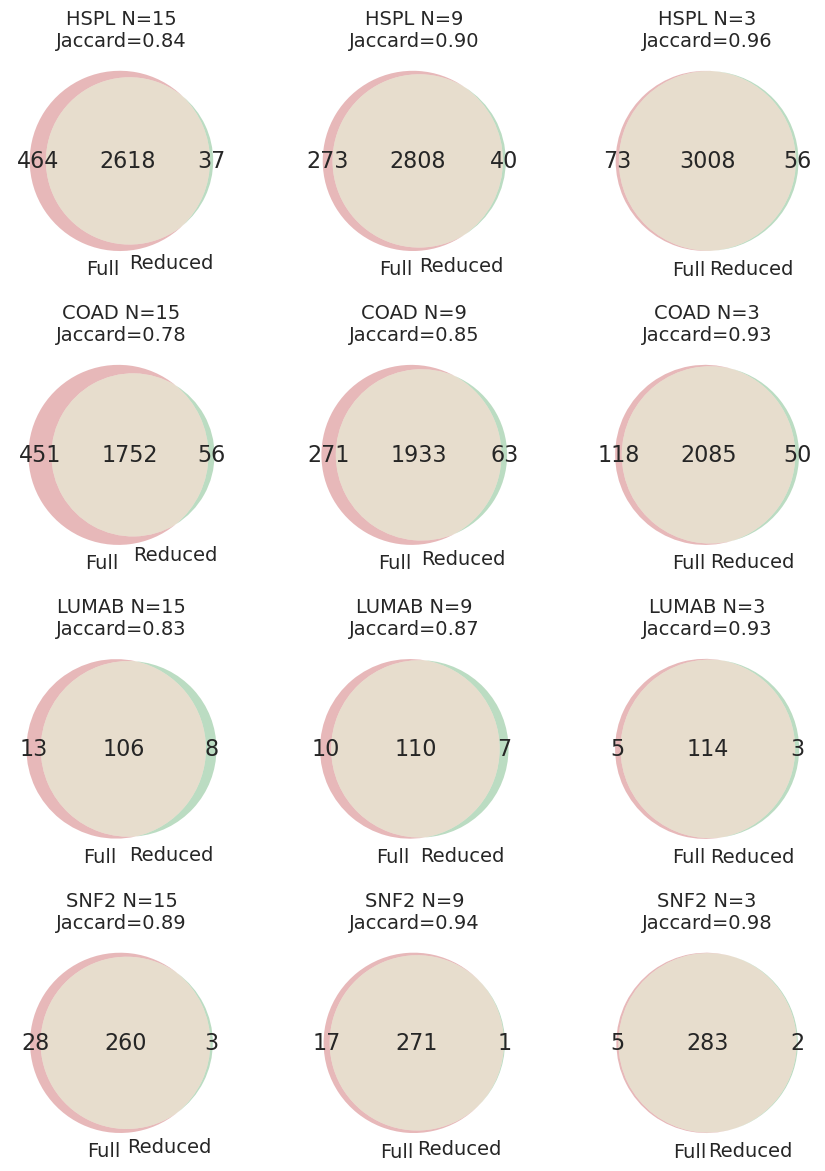

In [20]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

fig, axes = plt.subplots(len(to_test),len(Ns),figsize=(9,12))

for ax_col, data in zip(axes, res_dict):
    name = prdata_inv[data] if data in prdata_inv else data
    
    for ax, N in zip(ax_col, Ns):
        left = int(np.mean(res_dict[name][N]["fulldiff"]))
        inter = int(np.mean(res_dict[name][N]["inter"]))
        right = int(np.mean(res_dict[name][N]["reduceddiff"]))
        out = venn2(subsets = (left, right, inter), set_labels = ('Full', 'Reduced'),ax=ax)
        #ax.set_title(f"{data} N={N}\nJaccard={np.mean(res_dict[name][N]["jacc"]):.2f}",fontsize=14)
        jacc = inter / (left + inter + right)
        ax.set_title(f"{data} N={N}\nJaccard={jacc:.2f}",fontsize=14)

        for text in out.set_labels:
            text.set_fontsize(14)
        for text in out.subset_labels:
            text.set_fontsize(16)


fig.tight_layout()
figpath = f"../figures/sfig22_venn2.pdf"
fig.savefig(figpath, bbox_inches="tight")
print(figpath)

# Sup. Figure 21: Spearman variability

In [ ]:
site = "liver"
Ns = [5,10]

dfs = []
for N in Ns:
    spear, prec, rec = [], [], []
    for site in sites:
    
        data = sites[site]
        pretty_data = data if data not in prdata else prdata[data]
        ps = get_paramset(pretty_data)
        
        f = f"../data/{site}/{data}/{data}_N{N}/all.FDR.none.deseq2.{ps}.feather"
        tab = open_table(f).iloc[:,:50]
        f = f"../data/{site}/{data}/{data}.deseq2.lfc1.csv"
        truth = open_table(f)
        truth = truth["FDR"]<0.05
        predictions = (tab<0.05)
    
        # TP, FP, TN, FN
        TP = (truth.T & predictions.T).T
        FP = (~truth.T & predictions.T).T
        TN = (~truth.T & ~predictions.T).T
        FN = (truth.T & ~predictions.T).T
        
        # Precision and Recall
        precision = TP.sum(axis=0) / (TP.sum(axis=0) + FP.sum(axis=0))
        recall = TP.sum(axis=0) / (TP.sum(axis=0) + FN.sum(axis=0))
    
        sp = df_boot[(df_boot["N"]==N)&(df_boot["Data"]==pretty_data) & (df_boot["Reference"]=="Cohort")].groupby("Cohort")["Spearman"].mean()
        print(data)
        assert len(sp) == 50
        spear.append(sp)
        prec.append(precision)
        rec.append(recall)
    
    df = pd.DataFrame(np.array([pd.concat(spear).values, pd.concat(prec).values, pd.concat(rec).values]).T, columns=["Spearman","Precision","Recall"])
    dfs.append(df)

df = pd.concat(dfs)
df["N"] = 5
df["N"].iloc[len(df)//2:] = 10

In [23]:
up = 0.9
low = 0.8

for N in Ns:
    dfN = df[df["N"] == N]
    
    hs = (dfN["Spearman"] > up)
    hp= (dfN["Precision"] > up)
    ms = ((dfN["Spearman"] > low) & (dfN["Spearman"] <= up))
    mp = ((dfN["Precision"] > low) & (dfN["Precision"] <= up))
    ls = (dfN["Spearman"]<low)
    lp = (dfN["Precision"]<low)

    print(f"\nN={N}")
    pusu = (hs & hp).sum() / hs.sum()
    print(f"P(prec > {up} | spear > {up}) = {(hs & hp).sum()} / {hs.sum()} = {pusu:.3f}")
    
    pmsu = (lp & hs).sum() / hs.sum()
    print(f"P(prec < {low} | spear > {up}) = {(lp & hs).sum()} / {hs.sum()} = {pmsu:.3f}")
    
    plsl = (lp & ls).sum() / ls.sum()
    print(f"P(prec < {low} | spear < {low}) = {(lp & ls).sum()} / {ls.sum()} = {plsl:.3f}")
    
    pusl = (hp & ls).sum() / ls.sum()
    print(f"P(prec > {up} | spear < {low}) = {(hp & ls).sum()} / {ls.sum()} = {pusl:.3f}")


N=5
P(prec > 0.9 | spear > 0.9) = 240 / 284 = 0.845
P(prec < 0.8 | spear > 0.9) = 15 / 284 = 0.053
P(prec < 0.8 | spear < 0.8) = 217 / 276 = 0.786
P(prec > 0.9 | spear < 0.8) = 12 / 276 = 0.043

N=10
P(prec > 0.9 | spear > 0.9) = 340 / 355 = 0.958
P(prec < 0.8 | spear > 0.9) = 4 / 355 = 0.011
P(prec < 0.8 | spear < 0.8) = 146 / 206 = 0.709
P(prec > 0.9 | spear < 0.8) = 21 / 206 = 0.102


/scratch/local/18709872/ipykernel_1613749/4014535009.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
/scratch/local/18709872/ipykernel_1613749/4014535009.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')


../figures/sfig.spearman.var.pdf


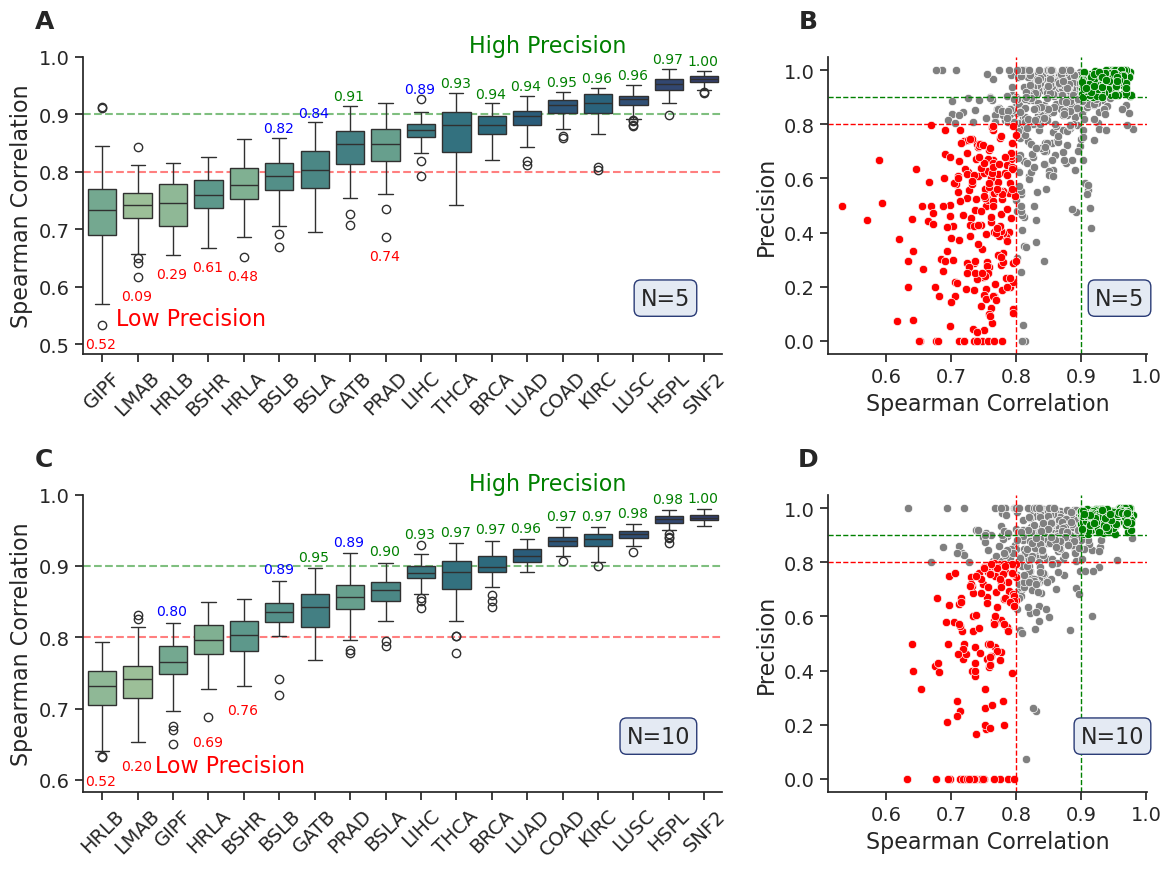

In [25]:
dfmo = dfm
order_prec = dfmo.sort_values(by="Prec_N10").index
Ns = [5,10]

with sns.axes_style("ticks"):

    fig, axes = plt.subplots(2,2,figsize=(12,9), gridspec_kw={'width_ratios': [2, 1]})
    axes = axes.T
    sns.despine()

    for k, (ax, N) in enumerate(zip(axes[0], Ns)):
    
        res_dict = {d:None for d in order_rep}
        for data in order_rep:
            d = df_boot
            d = d[(d["Reference"]=="Cohort")&(d["N"]==N)].reset_index()
            d = d[d["Data"]==data]
            mean = d["Spearman"].median()
            std = d.groupby("Cohort")["Spearman"].mean().std()
            #res_dict[data] = (mean,std)
            res_dict[data] = d.groupby("Cohort")["Spearman"].mean()
            v=pd.DataFrame(res_dict)

        order_spear = v.median().sort_values().index
        order = order_spear
        v=v[order]
        
        sns.boxplot(data=v,palette=palette, hue_order=order_rep,ax=ax)#,whis=[2.5, 97.5])
        vm = v.max()
        vmin = v.min()
        for i, d in enumerate(v):
            prec = dfmo.loc[d,f"Prec_N{N}"].round(2)
            yloc = (vm.loc[d] if prec>=0.8 else (vmin.loc[d]-0.05))+0.01
            if prec==0.8 and k==0: yloc = 0.85
            if prec==0.9 and k==0: yloc += 0.008
            ax.text(s=f"{prec:.02f}", 
                    x=i-0.47, 
                    y=yloc, 
                    fontsize=10,color="green" if prec >= 0.9 else "blue" if prec >= 0.8 else "red")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
        ax.axhline(0.9,color="green",ls="--",zorder=0,alpha=0.5)
        ax.axhline(0.8,color="red",ls="--",zorder=0,alpha=0.5)
        ax.set_ylim(min(vmin)-0.05,1)
        ax.set_xlim(-0.55,ax.get_xlim()[1])
        ax.set(ylabel="Spearman Correlation")
        sns.despine()
    
        ax.text(s=f"N={N}",x=0.95,y=0.15,va="bottom",ha="right",bbox=boxprops,transform=ax.transAxes)
        ax.text(s="Low Precision",x=0.23 if k>0 else 0.17,y=0.09 if k>0 else 0.12,va="center",ha="center",transform=ax.transAxes,color="red")
        ax.text(s="High Precision",x=0.85,y=1,va="bottom",ha="right",transform=ax.transAxes,color="green")

for i, N in enumerate(Ns):
    a = axes[1][i]
    sns.scatterplot(data=df[df["N"]==N], x="Spearman", y="Precision", ax=a, color="grey", alpha=1)
    correct_high = df[(df["N"]==N) & (df["Spearman"] > up) & (df["Precision"] > up)]
    sns.scatterplot(data=correct_high, x="Spearman", y="Precision", ax=a, color="green", alpha=1)
    correct_low = df[(df["N"]==N) & (df["Spearman"] < low) & (df["Precision"] < low)]
    sns.scatterplot(data=correct_low, x="Spearman", y="Precision", ax=a, color="red", alpha=1)
    lw = 1
    a.axhline(0.8, color="red", ls="--", lw=lw)
    a.axhline(0.9, color="green", ls="--", lw=lw)
    a.axvline(0.8, color="red", ls="--",lw=lw)
    a.axvline(0.9, color="green", ls="--",lw=lw)
    a.set(xlabel="Spearman Correlation", ylabel="Precision")
    a.text(s=f"N={N}",x=0.99,y=0.15,va="bottom",ha="right",bbox=boxprops,transform=a.transAxes)
    if i == 0:
        xlim = a.get_xlim()
    else:
        a.set_xlim(xlim)
        
for i, a in enumerate(axes.T.flatten()):
    a.annotate(chr(ord('A')+i), xy=(-0.06, 1.12), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)

figpath = "../figures/sfig.spearman.var.pdf"
fig.tight_layout()
fig.savefig(figpath, bbox_inches="tight")
print(figpath)

# Sup. Fig. 44 - Shrunk vs unshrunk metrics

/scratch/local/17348425/ipykernel_1522954/2701320200.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(data=aaa,x="DEA",y=f"median_{metric}",hue="DEA",ax=ax[0],palette=npg)
/scratch/local/17348425/ipykernel_1522954/2701320200.py:16: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(data=aaa,x="DEA",y=f"median_{metric}",hue="DEA",ax=ax[1],palette=npg)
/scratch/local/17348425/ipykernel_1522954/2701320200.py:20: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(data=aaa,x="DEA",y=f"median_{metric}",hue="DEA",ax=ax[2],palette=npg)
/scratch/local/17348425/ipykernel_1522954/2701320200.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(data=aaa,x="DEA",y=f"median_{metric}",hue="DEA",ax=ax[0],palette=npg)
/scratch/local/17348425/ipykernel_1522954/2701

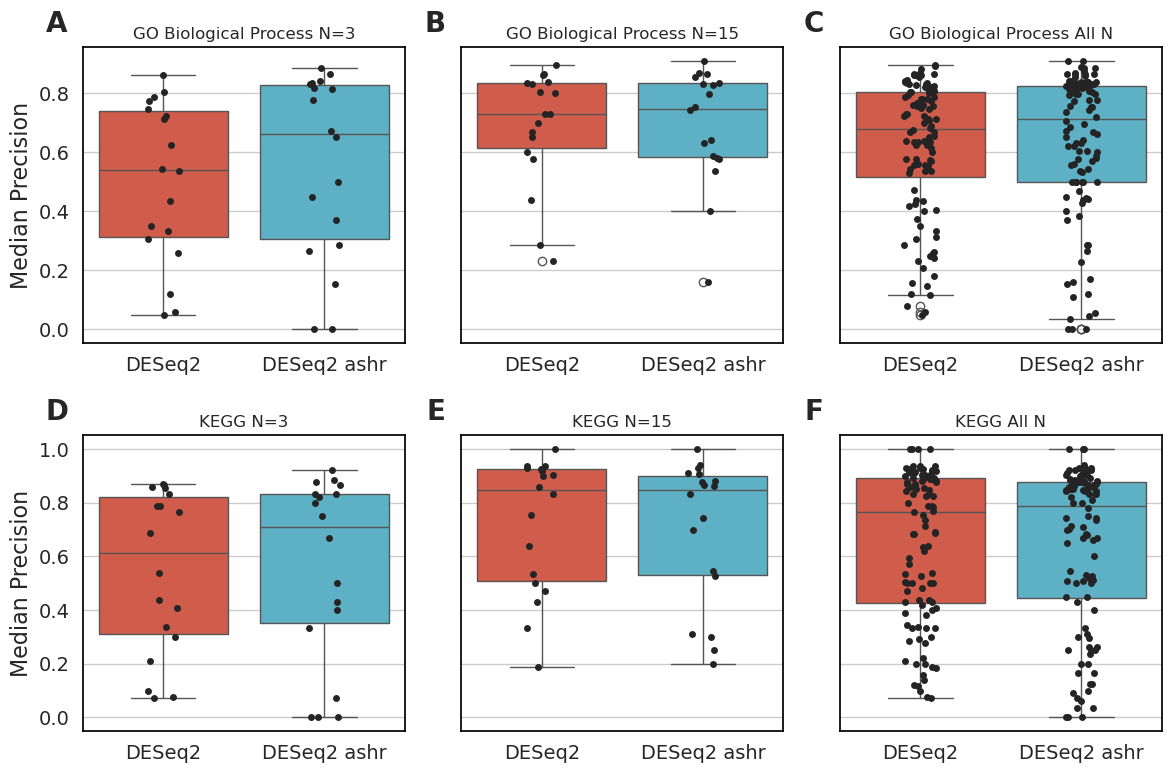

In [14]:
fig, axes = plt.subplots(2,3,figsize=(12,8), sharey="row")

metric = "prec"

for ax, lib in zip(axes, reversed(list(set(combined_gsea["Library"])))):
    aa=combined_gsea
    aa.replace({"DEA": {"deseq2_ashr":"DESeq2 ashr"}}, inplace=True)
    aaa=aa[(aa["Library"]==lib) & (aa["N"]==3)]
    sns.boxplot(data=aaa,x="DEA",y=f"median_{metric}",hue="DEA",ax=ax[0],palette=npg)
    sns.stripplot(data=aaa,x="DEA",y=f"median_{metric}",color="#242424",ax=ax[0])
    ax[0].set(ylabel=f"Median {pretty_met[metric]}", title=lib.replace("_"," ")  + " N=3")
    ax[1].set(title=lib.replace("_"," ") + " N=15")
    ax[2].set(title=lib.replace("_"," ") + " All N")

    aaa=aa[(aa["Library"]==lib) & (aa["N"]==15)]
    sns.boxplot(data=aaa,x="DEA",y=f"median_{metric}",hue="DEA",ax=ax[1],palette=npg)
    sns.stripplot(data=aaa,x="DEA",y=f"median_{metric}",color="#242424",ax=ax[1])

    aaa=aa[(aa["Library"]==lib)]
    sns.boxplot(data=aaa,x="DEA",y=f"median_{metric}",hue="DEA",ax=ax[2],palette=npg)
    sns.stripplot(data=aaa,x="DEA",y=f"median_{metric}",color="#242424",ax=ax[2])
    
for i, a in enumerate(axes.flatten()):
    a.set(xlabel=None)
    a.annotate(chr(ord('A')+i), xy=(-0.08, 1.08), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=20)
fig.tight_layout()

i = 44 if metric == "prec" else (45 if metric == "rec" else 46)
figpath = f"../figures/sfig{i}.deseq2_vs_ashr.{metric}.pdf"
fig.savefig(figpath, bbox_inches="tight")

# Unused figures

Data exploration, etc.

In [ ]:
f="../data/breast_lumab/LUMAB/LUMAB_N3/all.logFC.none.deseq2_apeglm.p2c.feather"
tab = open_table(f)

In [29]:
lib = "KEGG_2021_Human"
lib = "GO_Biological_Process_2023"
data = "BASHER"

tab = open_table(f"{datasets[data]['outpath']}/gsea/gseapy.logFC.{lib}.deseq2.feather")
tab2 = open_table(f"{datasets[data]['outpath']}/gsea/gseapy.logFC.{lib}.deseq2_ashr.feather")
tab3 = open_table(f"{datasets[data]['outpath']}/gsea/gseapy.logFC.{lib}.deseq2_apeglm.feather")

In [30]:
sig = tab[tab["FDR"]<0.05]
sig2 = tab2[tab2["FDR"]<0.05]
sig3 = tab3[tab3["FDR"]<0.05]
inter = sig.index.intersection(sig2.index)
union = sig.index.union(sig2.index)
jacc = len(inter) / len(union)
len(sig), len(sig2), len(sig3), len(inter), len(union), jacc

(19, 13, 223, 9, 23, 0.391304347826087)

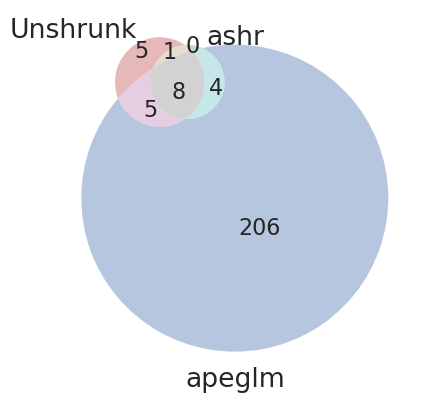

In [31]:
from matplotlib_venn import venn3

venn3([set(sig.index),set(sig2.index),set(sig3.index)], set_labels = ('Unshrunk',"ashr","apeglm"))

In [151]:
lib = "GO_Biological_Process_2023"
lib = "KEGG_2021_Human"

gmt=pd.read_csv(f"../data/enrichr/{lib}.tsv", index_col=0,sep="\t")

In [ ]:
al=[]
for j, i in enumerate(gmt.index):
    a=gmt.loc[i].dropna()
    print(i, len(a))
    al.append(len(a))
    if j > 100: break
print(np.median(al))

In [154]:
cols = len(gmt.columns)
ngenes = cols - gmt.isna().sum(axis=1)
ngenes.median()

np.float64(79.0)

In [123]:
Ns = [3,7,15]

lib = "GO_Biological_Process_2023"
#lib = "KEGG_2021_Human"
rd = dict()

for N in Ns:
    for data in datasets:
        if data == "SNF2": continue
        p = datasets[data]["outpath"]
        name = prdata[data] if data in prdata else data

        # logFC std
        pp = f"{p}/{data}_N{N}/all.FDR.gseapy.logFC.{lib}.none.deseq2.p2.feather"
        tab = open_table(pp)
        rd[(data,N,"std")] = (tab<0.05).sum().std()
        rd[(data,N,"mean")] = (tab<0.05).sum().mean()

<Axes: xlabel='N', ylabel='Val'>

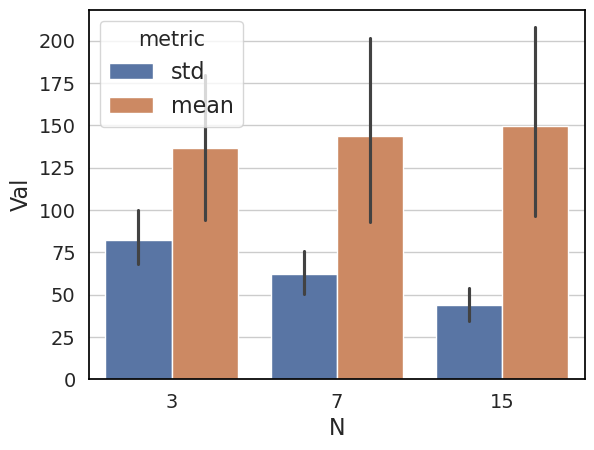

In [124]:
d = pd.DataFrame(rd.values(), index=rd.keys(), columns=["Val"])
d = d.reset_index(names=["Data","N","metric"])
sns.barplot(data=d,x="N",y="Val",hue="metric")

In [ ]:
Ns = [3,10]

for N in Ns:
    for data in datasets:
        p = datasets[data]["outpath"]
        name = prdata[data] if data in prdata else data
        ps = get_paramset(name)

        pp = f"{p}/{data}_N{N}/all.logFC.none.deseq2.{ps}.feather"
        tab = open_table(pp)
        assert 0

LIHC


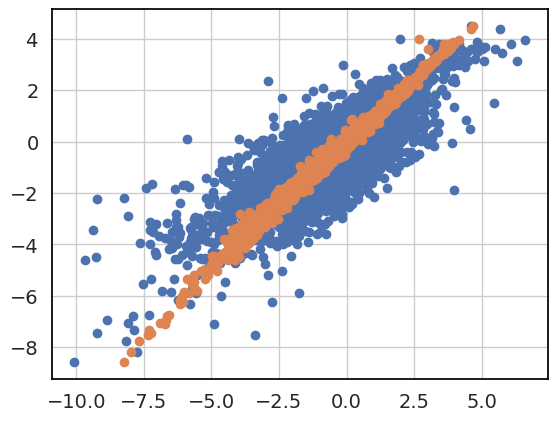

In [223]:
# Average logFC of many small cohorts approximates ground truth logFC from big cohort

print(data)
f = f"{datasets[data]["outpath"]}/{data}.deseq2.lfc1.csv"
truth_lfc = pd.read_csv(f, index_col=0)["logFC"]
plt.scatter(tab["1"], truth_lfc)
plt.scatter(tab.mean(axis=1), truth_lfc)

## lfc inflation

In [ ]:
f = "../data/liver/LIHC/LIHC.deseq2_ashr.lfc0.csv"
tab = pd.read_csv(f, index_col=0)
f = "../data/liver/LIHC/LIHC.deseq2_apeglm.lfc0.csv"
tab4 = pd.read_csv(f, index_col=0)
f = "../data/liver/LIHC/LIHC.deseq2.lfc1.csv"
tab2 = pd.read_csv(f, index_col=0)
f = "../data/liver/LIHC/LIHC.deseq2.lfc0.csv"
tab3 = pd.read_csv(f, index_col=0)

In [23]:
sig=tab[(tab["FDR"]<0.05) & (tab["logFC"].abs()>1)]
sig3=tab3[(tab3["FDR"]<0.05) & (tab3["logFC"].abs()>1)]
sig2=tab2[(tab2["FDR"]<0.05)]

len(sig), len(sig2), len(sig3)

(2403, 1196, 2679)

<Axes: xlabel='logFC', ylabel='Density'>

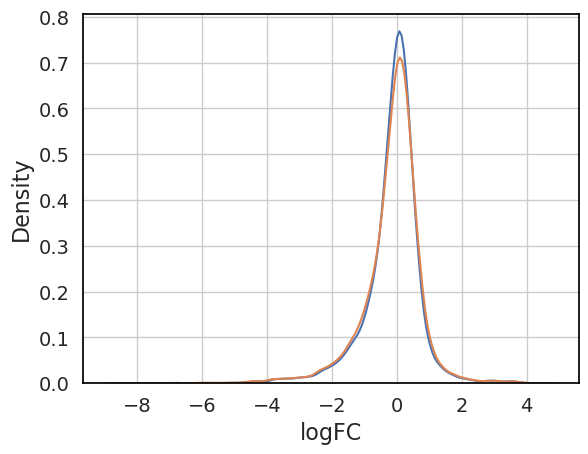

In [28]:
sns.kdeplot(tab["logFC"])
sns.kdeplot(tab2["logFC"])

In [106]:
Ns = [3,4,5,6,7,8,9,10,12,15]
nd = dict()

data = "BRCA"
for N in Ns:
    p = datasets[data]["outpath"]
    name = prdata[data] if data in prdata else data
    ps = get_paramset(name)

    # logFC std
    pp = f"{p}/{data}_N{N}/all.logFC.none.deseq2.{ps}.feather"
    tab = open_table(pp)
    nd[N] = tab

truth = pd.read_csv("../data/breast/BRCA/BRCA.deseq2.lfc1.csv", index_col=0)
truth_post = pd.read_csv("../data/breast/BRCA/BRCA.deseq2.lfc0.csv", index_col=0)
ndeg_truth = len(truth[truth["FDR"]<0.05])
ndeg_truth_post = len(truth_post[(truth_post["FDR"]<0.05)&(truth_post["logFC"].abs()>1)])

Text(0.5, 1.0, 'BRCA')

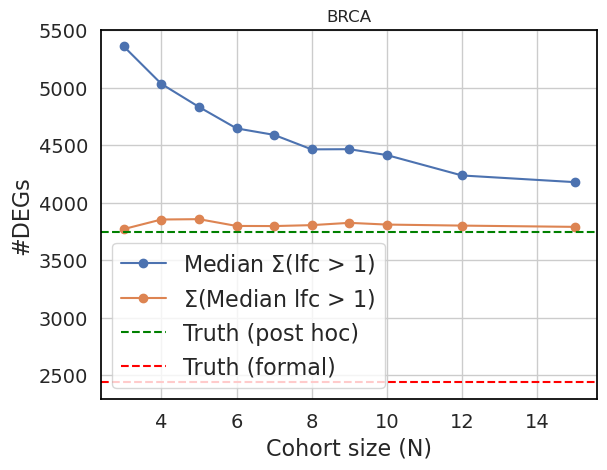

In [117]:
ndeg = []
ndeg2 = []
for N in Ns:
    a = nd[N].median(axis=1)
    b=(a.abs() > 1).sum()
    c=(nd[N].abs()>1).sum().median()
    ndeg.append(b)
    ndeg2.append(c)

plt.plot(Ns,ndeg2,label=r"Median $\Sigma$(lfc > 1)",marker="o")
plt.plot(Ns,ndeg,label=r"$\Sigma$(Median lfc > 1)",marker="o")

plt.axhline(ndeg_truth_post, ls="--", color="green",label="Truth (post hoc)")
plt.axhline(ndeg_truth, ls="--", color="red", label="Truth (formal)")
plt.ylabel("#DEGs")
plt.xlabel("Cohort size (N)")
plt.legend()
plt.title(data)

LUMAB
0.09937496576479875 0.05074473546990958


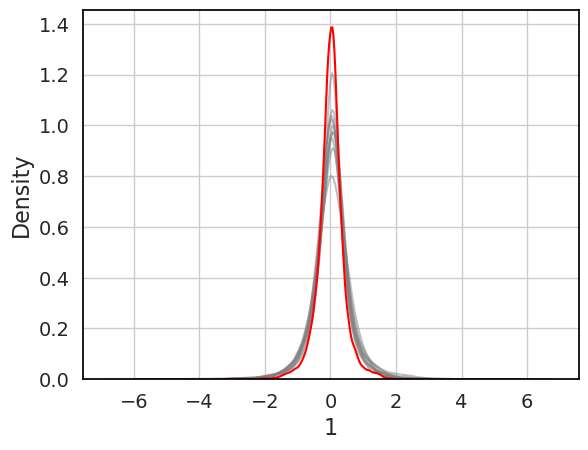

In [240]:
from misc import get_kl_div

print(data)
f = f"{datasets[data]["outpath"]}/{data}.deseq2.lfc1.csv"
truth_lfc = pd.read_csv(f, index_col=0)["logFC"]

kl_divs = []
for i in range(1,11):
    sns.kdeplot(tab[str(i)],color="grey",alpha=0.5)
    kl_divs.append(get_kl_div(truth_lfc, tab[str(i)], np.linspace(-5,5,50)))
    print(f"{i}\r", end="")
sns.kdeplot(truth_lfc,color="red",alpha=1)
print(np.mean(kl_divs), np.std(kl_divs))

LUMAB
0.9340964211560605 0.25409562211943676


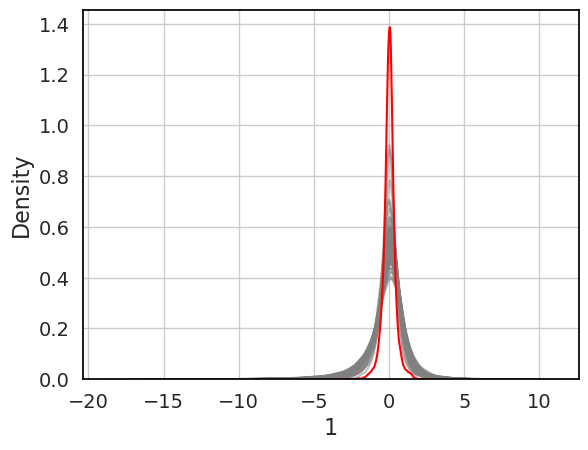

In [226]:
from misc import get_kl_div


print(data)
f = f"{datasets[data]["outpath"]}/{data}.deseq2.lfc1.csv"
truth_lfc = pd.read_csv(f, index_col=0)["logFC"]
kl_divs = []
for i in range(1,101):
    sns.kdeplot(tab[str(i)],color="grey",alpha=0.5)
    kl_divs.append(get_kl_div(truth_lfc, tab[str(i)], np.linspace(-5,5,50)))
    print(f"{i}\r", end="")
sns.kdeplot(truth_lfc,color="red",alpha=1)
print(np.mean(kl_divs), np.std(kl_divs))

LUMAB


[(-6.0, 6.0)]

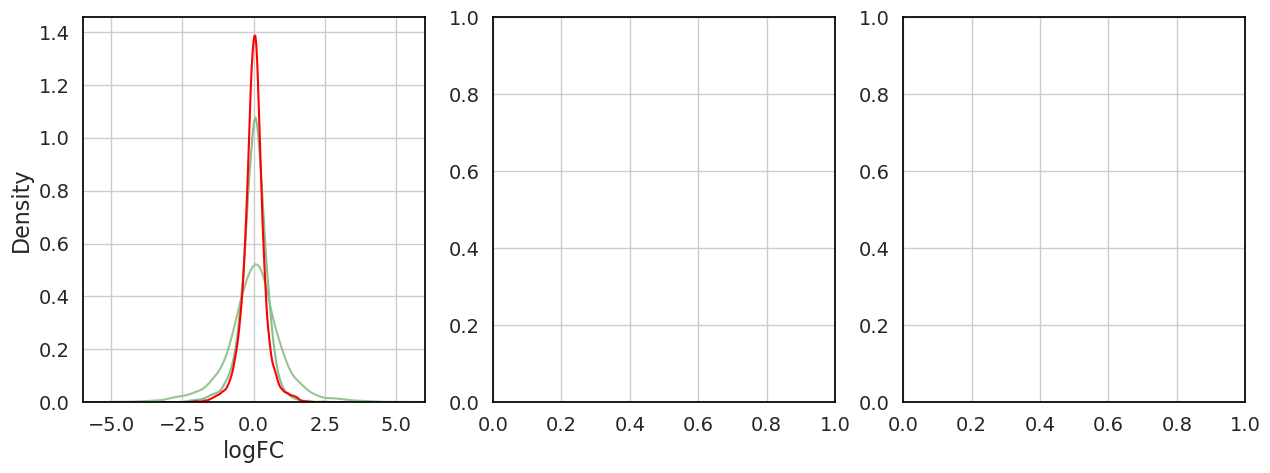

In [251]:
from misc import get_kl_div

print(data)
f = f"{datasets[data]["outpath"]}/{data}.deseq2.lfc1.csv"
truth_lfc = pd.read_csv(f, index_col=0)["logFC"]

fig, axes = plt.subplots(1,3,figsize=(15,5))
ax=axes[0]
for i, N in enumerate(Ns):    
    tab = nd[N].iloc[:100]
    sns.kdeplot(tab.values.flatten(),ax=ax,color=palette[i])
    #sns.kdeplot(tab.mean(axis=1),color="green",ax=ax)
sns.kdeplot(truth_lfc,color="red",alpha=1,ax=ax)
ax.set(xlim=(-6,6))

In [ ]:
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

met = "rep"
met = "mcc"
met = "prec"
#met = "deg"
#met = "rec"

suffix = "_method"

fig, ax = plt.subplots(4,3, figsize=(15,17), sharex=True, sharey="row")

deas = ["edgeR QLF","edgeR LRT","DESeq2 Wald"]
logFC = "0"
fdr = 0.05

df = combined_all[~combined_all["isSynthetic"]]
df = df[(df["logFC"]==1) & (df["lfc_mode"]=="formal")]
df = df[(df["FDR"]==0.05) & (df["Out"]=="None")]

#order_rep = np.array(["LUSC","COAD","KIRC","LUAD","BRCA","THCA","LIHC","PRAD"])
#order_rep = set(combined_all["Data"])
order_rep = df[(df["DEA"]=="edgeR LRT")&(df["N"]==3)].sort_values(by="median_prec_method")["Data"].values
def kf(x):
    print(order_rep,x)
    return np.where(order_rep==x)[0][0]

palette = jco[:len(order_rep)]

for j, dea in enumerate(deas):
    dea_print = rf"{dea}$_\mathrm{{TREAT}}$" if dea != "DESeq2 Wald" else dea
    ax[0][j].set_title(dea_print)
    
    for i, met in enumerate(["prec","rec","rep","deg"]):
        
        a = ax[i][j]
        c = df
        c = c.sort_values(by=['Data'], key=lambda col: col.map({k: i for i, k in enumerate(order_rep)}))
        cc = c[c["DEA"]==dea]
        if len(cc) < 1: 
            continue
    
        sns.lineplot(data=cc, x="N", y=f"median_{met}{suffix}", hue="Data", style="Data", markers=True, ax=a, palette=palette,lw=3,ms=14)
                
        prettymet = "MCC" if met.startswith("mcc") else ("Recall" if met == "rec" else ("Precision" if met.startswith("prec") else ("#DEG" if met == "deg" else "Replicability")))
        a.set_ylabel(f"Median {prettymet}")
        a.legend([],[], frameon=False)
        
handles, labels = ax[0][1].get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc="upper center", ncol=8, bbox_to_anchor=(0.5, 1.05),markerscale=1,framealpha=1)

for a in ax[-1]: a.set_xlabel("Cohort Size N")

prefix = "sfig2" if met == "deg" else "sfig3" if met == "rep" else "sfig4" if met.startswith("mcc") else "sfig5" if met == "rec" else "sfig6"
figpath = f"../figures/{prefix}_{met}_vs_N_data.pdf"
fig.tight_layout()
#fig.savefig(figpath)
print(figpath)

In [ ]:
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

method = "DESeq2 Wald"
all_N_sub = [3,5,9,15]

fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

df = combined_all[~combined_all["isSynthetic"]]

df = df[(df["logFC"]==1) & (df["lfc_mode"]=="formal") & (df["DEA"]==method)]
df = df[(df["N"]).isin(all_N_sub)]
sns.scatterplot(data=df, x="median_rec", y="median_prec", hue="N", style="Data", ax=ax, palette=npg,s=200)

for i, N in enumerate(all_N_sub):
    sns.kdeplot(data=df[df["N"]==N], x="median_rec", y="median_prec",color=npg[i],alpha=0.3)

ax.legend(framealpha=1,title=None,ncol=2,markerscale=1,bbox_to_anchor=(1,1))
ax.set(xlim=(-0.05,1.05),ylim=(-0.05,1.05))

In [ ]:
from adjustText import adjust_text

sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

method = "DESeq2 Wald"
all_N_sub = [3,5,9,15]

fig, ax = plt.subplots(1,4, figsize=(15,5), sharey=True, sharex=True)

df = combined_all[~combined_all["isSynthetic"]]

df = df[(df["logFC"]==1) & (df["lfc_mode"]=="formal") & (df["DEA"]==method)]

for i, N in enumerate(all_N_sub):
    df_N = df[df["N"]==N]
    sns.scatterplot(data=df_N, x="median_rec_method", y="median_prec_method", color=npg[i], style="Data", ax=ax[i], palette=npg,s=200)
    #sns.kdeplot(data=df_N, x="median_rec_method", y="median_prec_method",color=npg[i],alpha=0.3,ax=ax[i])

    ax[i].set(xlim=(-0.05,1.05),ylim=(-0.05,1.05))
    ax[i].legend([],[], frameon=False)
    ax[i].set_title(f"N={N}",color=npg[i], fontsize=20)
    ax[i].set(xlabel="Median Recall", ylabel="Median Precision")

    texts = []
    for x, y, s in zip(df_N["median_rec_method"], df_N["median_prec_method"], df_N["Data"]):
      texts.append(ax[i].text(x, y, s, size=12))    
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
    
handles, labels = ax[-1].get_legend_handles_labels()
handles, labels = handles[:-2], labels[:-2]
fig.legend(handles[::-1], labels[::-1], loc="upper center", ncol=8, bbox_to_anchor=(0.51, 1.15),markerscale=1,framealpha=1)
fig.tight_layout()

DESeq2 Wald [1.42730675 2.24568713]
edgeR LRT [1.15050868 1.47489306]
edgeR QLF [0.13412771 1.57863705]


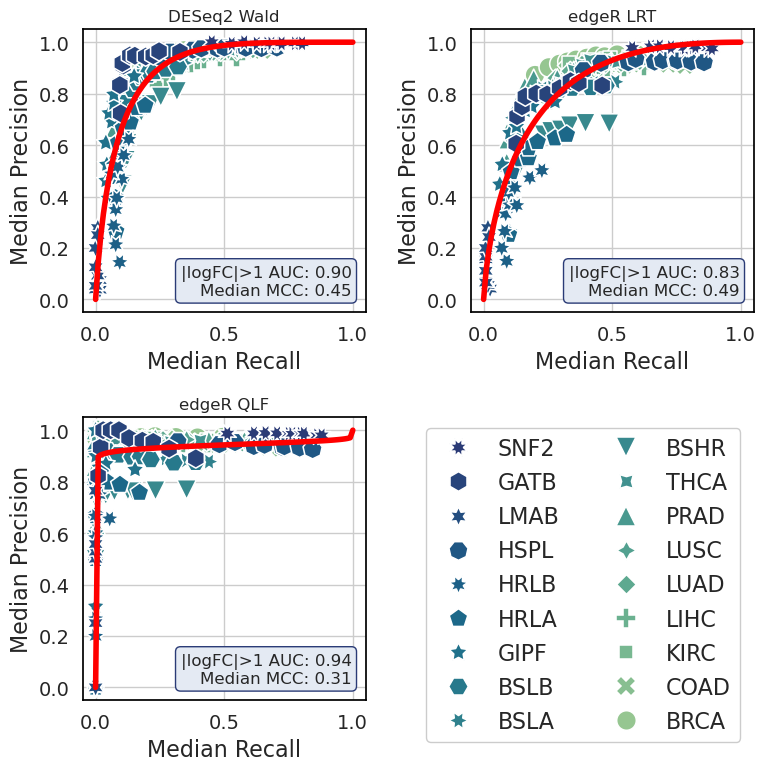

In [226]:
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.metrics import auc

scale=0.4
fig,ax=plt.subplots(2,2,figsize=(scale*20,scale*20))
axes=ax.flatten()

df_a = combined_all
df_a = df_a[(df_a["logFC"]==1) & (df_a["lfc_mode"]=="formal")]

methods = ["DESeq2 Wald","edgeR LRT","edgeR QLF"]
for ax, method in zip(axes[:-1], methods):

    df = df_a[df_a["DEA"]==method]
    sns.scatterplot(data=df, x="median_rec", y="median_prec", style="Data", hue="Data", palette=palette,s=200,alpha=1,ax=ax)
    ax.set(xlim=(-0.05,1.05),ylim=(-0.05,1.05))
    x = np.linspace(0,1,100)
    

    def binormal(x, a, b):
        return stats.norm.cdf(a * stats.norm.ppf(x) + b)
    
    params, _ = curve_fit(binormal, df['median_rec'], df['median_prec'], bounds=(0, np.inf))
    y_binormal = binormal(x, *params)
    sns.lineplot(x=x, y=y_binormal, color="red",lw=4,zorder=99,ax=ax)
    
    # params_data = [[]]
    # for data in set(df["Data"]):
    #     if data in ["LMAB","SNF2"]: continue
    #     df_d = df[df["Data"]==data]
    #     params_d, _ = curve_fit(binormal, df_d['median_rec'], df_d['median_prec'])
    #     params_data.append(params_d)
    #     y_binormal = binormal(x, *params_d)
    #     sns.lineplot(x=x, y=y_binormal,alpha=0.25,color="grey",ax=ax)
    print(method,params)
    ax.set(xlabel="Median Recall", ylabel="Median Precision")
    ax.set_aspect(1)
    auc_value = auc(x,y_binormal)
    ax.set_title(f"{method}")
    ax.legend([],[], frameon=False)
    ax.text(s=f"|logFC|>1 AUC: {auc_value:.2f}\nMedian MCC: {df['median_mcc_method'].median():.2f}",x=0.95,y=0.05, 
            transform=ax.transAxes, ha="right", va="bottom",bbox=boxprops,fontsize=12)

axes[-1].set_axis_off()
#axes[1].legend(loc="lower right",ncol=2,prop={'size': 12})
handles, labels = axes[-2].get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc="center", ncol=2, bbox_to_anchor=(0.75, 0.25),markerscale=1,framealpha=1)
fig.tight_layout()

## How many trials?

../figures/trials.png


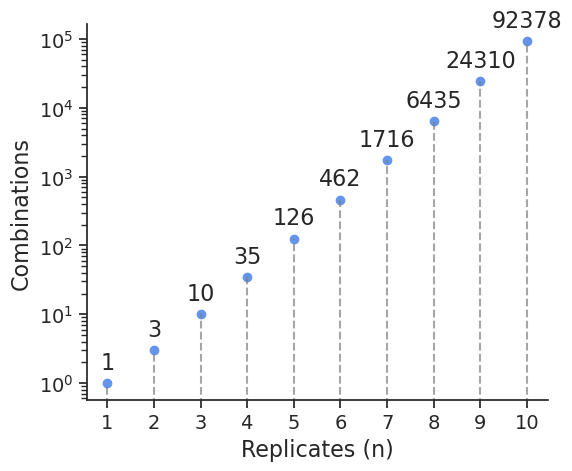

In [19]:
from math import comb

def comb_with_replace(n):
    return comb(2*n-1, n)

therange = range(1,11)

with sns.axes_style("ticks"):
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    for i in therange:
        y = comb_with_replace(i)
        ax.scatter(i,y,color="cornflowerblue")
        ax.text(i,2*y,y,ha="center",va="center")
        ax.plot((i,i), (0,y),color="grey",ls="--",alpha=0.7)
    ax.set_yscale("log")
    ax.set_xlabel("Replicates (n)")
    ax.set_ylabel("Combinations")
    ax.set_xticks(therange)
    sns.despine()

figpath = f"../figures/trials.png"
fig.tight_layout()
fig.savefig(figpath)
print(figpath)

## edegR vs DESeq2 lfc

In [10]:
Ns = [3,4,5,6,7,8,9,10,12,15]
nd = {N:dict() for N in Ns}

data = "BRCA"
for N in Ns:
    p = datasets[data]["outpath"]
    name = prdata[data] if data in prdata else data
    ps = get_paramset(name)

    pp = f"{p}/{data}_N{N}/all.logFC.none.deseq2.{ps}.feather"
    tab = open_table(pp)
    nd[N]["DESeq2"] = tab
    pp = f"{p}/{data}_N{N}/all.logFC.none.edgerlrt.{ps}.feather"
    tab = open_table(pp)
    nd[N]["edgeR"] = tab
    
# truth = pd.read_csv("../data/breast/BRCA/BRCA.deseq2.lfc1.csv", index_col=0)
# truth_post = pd.read_csv("../data/breast/BRCA/BRCA.deseq2.lfc0.csv", index_col=0)
# ndeg_truth = len(truth[truth["FDR"]<0.05])
# ndeg_truth_post = len(truth_post[(truth_post["FDR"]<0.05)&(truth_post["logFC"].abs()>1)])

In [29]:
N=15
a = nd[N]["DESeq2"].sort_index()
b = nd[N]["edgeR"].sort_index()

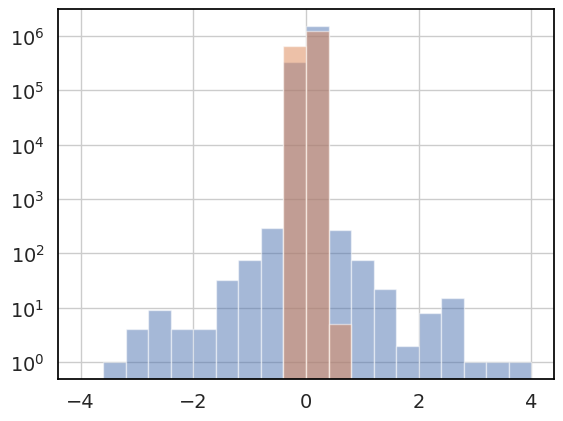

In [33]:
N=3
a = nd[N]["DESeq2"].sort_index()
b = nd[N]["edgeR"].sort_index()
plt.hist((a-b).values.flatten(),bins=20,range=(-4,4),alpha=0.5)

N=15
a = nd[N]["DESeq2"].sort_index()
b = nd[N]["edgeR"].sort_index()
plt.hist((a-b).values.flatten(),bins=20,range=(-4,4),alpha=0.5)

plt.yscale("log")